In [1]:
%matplotlib inline

from collections import Counter
from collections import defaultdict
import glob
import itertools
from itertools import izip
import os

import seaborn as sns
from matplotlib import pyplot
from matplotlib_venn import venn2, venn3
import pybedtools
import numpy as np
from IPython.core.display import HTML
import pandas as pd

from gscripts import GO
from gscripts.rnaseq import splicing_map
from gscripts.general import dataviz
from gscripts.general import region_helpers

img_dir = "/home/gpratt/Dropbox/cryptic_splicing/data/human_data/splicing_maps"
heatmap_dir = "/home/gpratt/Dropbox/cryptic_splicing/data/human_data/heatmaps"

/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [16]:
previous_cryptic_events = """EPB41L4A
CEP72
INSR
FAM114A2
PFKP
ST5
RNFT2
RNFT2
ALX1
AGRN
AGRN
ATG4B
AGRN
AGRN
ST5
SETD5
KDELC2
MUC16
PKN1
IRF9
UPF2
GPSM2
XPO4
RASA4
RASA4B
PARP6
KRT7
TRAPPC12
RANBP1
HERC6
BLZF1
ZFP91
HDGFRP2
MAP3K8
SSFA2
CENPK
ITPR3
KYNU
IRF9
COL4A6
KYNU""".split("\n")

In [17]:
import matplotlib as mpl
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [18]:
gene_id_to_name = region_helpers.gene_id_to_name("/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db")
ensembl_id_to_name = {key.split(".")[0]: value for key, value in gene_id_to_name.items()}

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

In [19]:
# from scipy.cluster import hierarchy
# from scipy.spatial import distance

# def leaves(t, t2=None):
#     """ Returns the leaves of a ClusterNode """
#     try:
#         return t.pre_order()
#     except AttributeError:
#         if t2 is not None:
#             return t2.pre_order()
#         else:
#             return []

# # For an element x, returns the set that x isn't in
# other = lambda x, V, W: W if x in V else V
# M = {}

# def optimal_scores(v, D, fast=True):
#     """ Implementation of Ziv-Bar-Joseph et al.'s leaf order algorithm
#     v is a ClusterNode
#     D is a distance matrix """
#     def score_func(left, right, u, m, w, k):
#         return Mfunc(left, u, m) + Mfunc(right, w, k) + D[m, k]
    
#     def Mfunc(v, a, b):
#         if a == b:
#             M[v, a, b] = 0
#         return M[v, a, b]
    
#     if v.is_leaf():
#         n = v.get_id()
#         M[v, n, n] = 0
#         return 0
#     else:
#         L = leaves(v.left)
#         R = leaves(v.right)
#         LL = leaves(v.left.left, v.left)
#         LR = leaves(v.left.right, v.left)
#         RL = leaves(v.right.left, v.right)
#         RR = leaves(v.right.right, v.right)
#         for l in L:
#             for r in R:
#                 M[v.left, l, r] = slow_optimal_scores(v.left, D)
#                 M[v.right, l, r] = slow_optimal_scores(v.right, D)
#                 for u in L:
#                     for w in R:
#                         if fast:
#                             m_order = sorted(other(u, LL, LR), key=lambda m: Mfunc(v.left, u, m))
#                             k_order = sorted(other(w, RL, RR), key=lambda k: Mfunc(v.right, w, k))
#                             C = min([D[m, k] for m in other(u, LL, LR) for k in other(w, RL, RR)])
#                             Cmin = 1e10
#                             for m in m_order:
#                                 if M[v.left, u, m] + M[v.right, w, k_order[0]] + C >= Cmin:
#                                     break
#                                 for k in k_order:
#                                     if M[v.left, u, m] + M[v.right, w, k] + C >= Cmin:
#                                         break
#                                     C = score_func(v.left, v.right, u, m, w, k)
#                                     if C < Cmin:
#                                         Cmin = C
#                             M[v, u, w] = M[v, w, u] = Cmin
#                         else:
#                             M[v, u, w] = M[v, w, u] = \
#                                 min([score_func(v.left, v.right, u, m, w, k) \
#                                     for m in other(u, LL, LR) \
#                                     for k in other(w, RL, RR)])
#                 return M[v, l, r]

# slow_optimal_scores = lambda v, D: optimal_scores(v, D, fast=False)
# fast_optimal_scores = lambda v, D: optimal_scores(v, D, fast=True)

# def order_tree(v, D, fM=None, scores=slow_optimal_scores):
#     """ Returns an optimally ordered tree """
#     # Generate scores the first pass
#     if fM is None:
#         fM = 1
#         scores(v, D)
    
#     L = leaves(v.left)
#     R = leaves(v.right)
#     if len(L) and len(R):
#         u, w = min([(u, w) for u in L for w in R], key=lambda (u,w): M[v, u, w])
#         if w in leaves(v.right.left):
#             v.right.right, v.right.left = v.right.left, v.right.right
#         if u in leaves(v.left.right):
#             v.left.left, v.left.right = v.left.right, v.left.left
#         v.left = order_tree(v.left, D, fM)
#         v.right = order_tree(v.right, D, fM)
#     return v

# @property
# def reordered_ind(self):
#     M = {}
#     tree = hierarchy.to_tree(self.linkage)
#     dists = distance.squareform(distance.pdist(self.array, metric=self.metric))
#     return leaves(order_tree(tree, dists))

# old_ind = sns.matrix._DendrogramPlotter.reordered_ind
# sns.matrix._DendrogramPlotter.reordered_ind = reordered_ind

#Assemble Useful Tables

In [2]:
# master_processing_table = pd.read_table("/home/elvannostrand/data/ENCODE/project_stuff/ENCODE_MASTER_ID_LIST_20160301_AllDatasets.txt", 
#                                         sep="\t",
#                                         skiprows=1,
#                                         names=["UID", "RBP_gID", "CellLine", "RBP_ENSG", "Antibody", "Lot", "CLIP_ENCODEAccID", "CLIP_Rep1ENC", "CLIP_Rep2ENC", "CLIP_InputENC", "RNASEQ_ENCODEAccID",  "Duplicate_RNASEQ_ENCODEAccID", "RNASEQ_ControlENC", "RNASEQ_KDRep1Bam", "RNASEQ_KDRep2Bam", "RNASEQ_ControlRep1Bam", "RNASEQ_ControlRep2Bam", "bar"]
# )

` = pd.read_table("/home/gpratt/Dropbox/encode_integration/20160408_ENCODE_MASTER_ID_LIST_AllDatasets.csv", index_col=0 )

In [5]:
master_processing_table

uID   RBP_gID CellLine  \
0         202     PTBP1    HepG2   
1         203    HNRNPC    HepG2   
2         204    RBFOX2    HepG2   
3         205   IGF2BP1    HepG2   
4         206    HNRNPK    HepG2   
5         209     SRSF7    HepG2   
6         211   IGF2BP3    HepG2   
7         213     RBM34    HepG2   
8         214   IGF2BP2    HepG2   
9         215      TIA1    HepG2   
10        216     SRSF9    HepG2   
11        218     TRA2A    HepG2   
12        219     ASCC1    HepG2   
13        220   IGF2BP1     K562   
14        222    HNRNPM    HepG2   
15        223     FKBP4    HepG2   
16        224    HNRNPM     K562   
17        225     PRPF6    HepG2   
18        226   IGF2BP2     K562   
19        227      SLTM    HepG2   
20        228     SF3B4    HepG2   
21        230     BCCIP    HepG2   
22        232    EIF4A3    HepG2   
23        235      XRN2    HepG2   
24   235x4000      XRN2    HepG2   
25        236      FMR1     K562   
26        237      FXR2     K562   
27        237      FXR2     K562   
28        240     TRA2A     K562   
29        241     DDX42     K562   
..        ...       ...      ...   
452       NaN    TRIM56    HepG2   
453       NaN     DHX30     K562   
454       NaN     SRSF9     K562   
455       NaN    METAP2    HepG2   
456       NaN  APOBEC3C     K562   
457       NaN      AGO3     K562   
458       NaN     SRP68     K562   
459       NaN   FASTKD2    HepG2   
460       NaN     SART3     K562   
461       NaN    PPP1R8     K562   
462       NaN     SSRP1    HepG2   
463       NaN    SERBP1     K562   
464       NaN       SSB     K562   
465       NaN    TRIM56     K562   
466       NaN    RBFOX2     K562   
467       NaN    FIP1L1    HepG2   
468       NaN      SLBP    HepG2   
469       NaN     DDX28    HepG2   
470       NaN     RPS3A     K562   
471       NaN     G3BP1    HepG2   
472       NaN      ILF3    HepG2   
473       NaN     SART3    HepG2   
474       NaN      PPIG     K562   
475       NaN    AKAP8L    HepG2   
476       NaN     DDX27    HepG2   
477       NaN      UPF2     K562   
478       NaN      PUS1    HepG2   
479       NaN      ACO1    HepG2   
480       NaN    SUPT6H     K562   
481       NaN     NAA15    HepG2   

                                             CLIP_rep1  \
0    /projects/ps-yeolab2/encode/analysis/encode_v1...   
1    /projects/ps-yeolab2/encode/analysis/encode_v1...   
2    /projects/ps-yeolab2/encode/analysis/encode_v1...   
3    /projects/ps-yeolab2/encode/analysis/encode_v1...   
4    /projects/ps-yeolab2/encode/analysis/encode_v1...   
5    /projects/ps-yeolab2/encode/analysis/encode_v1...   
6    /projects/ps-yeolab2/encode/analysis/encode_v1...   
7    /projects/ps-yeolab2/encode/analysis/encode_v1...   
8    /projects/ps-yeolab2/encode/analysis/encode_v1...   
9    /projects/ps-yeolab2/encode/analysis/encode_v1...   
10   /projects/ps-yeolab2/encode/analysis/encode_v1...   
11   /projects/ps-yeolab2/encode/analysis/encode_v1...   
12   /projects/ps-yeolab2/encode/analysis/encode_v1...   
13   /projects/ps-yeolab2/encode/analysis/encode_v1...   
14   /projects/ps-yeolab2/encode/analysis/encode_v1...   
15   /projects/ps-yeolab2/encode/analysis/encode_v1...   
16   /projects/ps-yeolab2/encode/analysis/encode_v1...   
17   /projects/ps-yeolab2/encode/analysis/encode_v1...   
18   /projects/ps-yeolab2/encode/analysis/encode_v1...   
19   /projects/ps-yeolab2/encode/analysis/encode_v1...   
20   /projects/ps-yeolab2/encode/analysis/encode_v1...   
21   /projects/ps-yeolab2/encode/analysis/encode_v1...   
22   /projects/ps-yeolab2/encode/analysis/encode_v1...   
23   /projects/ps-yeolab2/encode/analysis/encode_v1...   
24   /projects/ps-yeolab/encode/analysis/encode_v13...   
25   /projects/ps-yeolab2/encode/analysis/encode_v1...   
26   /projects/ps-yeolab2/encode/analysis/encode_v1...   
27   /projects/ps-yeolab2/encode/analysis/encode_v1...   
28   /projects/ps-yeolab2/encode/analysis/encode_v1...   
29   /projects/ps-yeolab2/encode/anal

In [21]:
rna_only_data = master_processing_table[master_processing_table.selection_method != "polyadenylated mRNA"].RNASEQ_ENCODEAccID.dropna()

#Load SE Events

In [ ]:
dtypes = {"1stExonEnd": np.float64,
"1stExonStart_0base": np.float64,
"2ndExonEnd": np.float64,
"2ndExonStart_0base": np.float64,
"FDR": np.float64,
"GeneID": str,
"ID.1": np.int32,
"IJC_SAMPLE_1": str,
"IJC_SAMPLE_2": str,
"IncFormLen": np.int32,
"IncLevel1": str,
"IncLevel2": str,
"IncLevelDifference": np.float64,
"PValue": np.float64,
"SJC_SAMPLE_1": str,
"SJC_SAMPLE_2": str,
"SkipFormLen": np.int32,
"chr": str,
"downstreamEE": np.float64,
"downstreamES":np.float64,
"exonEnd":np.float64,
"exonStart_0base":np.float64,
"flankingEE":np.float64,
"flankingES":np.float64,
"geneSymbol": str,
"group_id": str,
"is_cryptic": np.bool,
"longExonEnd": np.float64,
"longExonStart_0base": np.float64,
"riExonEnd": np.float64,
"riExonStart_0base": np.float64,
"shortEE": np.float64,
"shortES": np.float64,
"strand": str,
"upstreamEE": np.float64,
"upstreamES": np.float64,
"RNASEQ_ENCODEAccID": str,
"rbp.1": str,
"cell_type.1": str,
"both.1": str}

In [ ]:
all_events = pd.read_csv("/home/gpratt/projects/cryptic_exons/analysis/ipython_data/merged_cryptic_events.csv", 
            index_col=[0,1,2,3,4,5], dtype=dtypes)

all_events.rename(columns={"rbp.1": "rbp", "cell_type.1": "cell_type", "both.1": "both"}, inplace=True)
id_to_name = dict(izip(all_events.index.get_level_values(level="condition"), all_events.index.get_level_values(level="both")))
all_events = all_events.drop("MN", level="cell_type")
all_events['condition'] = all_events.index.get_level_values("condition").map(lambda x: x.split("_vs_")[0])
all_events = all_events[~all_events['condition'].isin(rna_only_data)]

In [ ]:
all_events.info()

In [ ]:
def get_significant_events(events):
    sig_events = events[events.FDR < .05]
    sig_events = sig_events[np.abs(sig_events.IncLevelDifference) > .2]
    sig_events = pd.concat({"excluded": sig_events[sig_events.IncLevelDifference < 0],
                            "included": sig_events[sig_events.IncLevelDifference > 0],}, 
                           names=["direction", "event_type", "condition", "both", "rbp", "cell_type", "event_id"])
    sig_events = sig_events.swaplevel(0,1)
    return sig_events

all_sig_events = get_significant_events(all_events)
background_events = all_events[all_events.FDR > .05]

all_sig_stress_events = all_sig_events[all_sig_events.rbp.isin(['CA', 'PQ', 'PQCA', 'ars', 'hs'])]
background_stress_events = background_events[background_events.rbp.isin(['CA', 'PQ', 'PQCA', 'ars', 'hs'])]

#Count number of events

In [ ]:
num_events = all_sig_stress_events.groupby(level=["event_type", "direction", "condition"]).count().GeneID.unstack().T

In [ ]:
num_events_encode = all_sig_events.groupby(level=["event_type", "direction", "condition"]).count().GeneID.unstack().T 

In [ ]:
tdp43_only = all_sig_events[all_sig_events.rbp == "TARDBP"]

In [ ]:
tdp43_only = tdp43_only.ix['SE'].dropna(how='all', axis=1)

In [ ]:
tdp43_only["upstreamES"]= tdp43_only.upstreamES.astype(int)
tdp43_only["downstreamEE"]= tdp43_only.downstreamEE.astype(int)
tdp43_only["exonStart_0base"]= tdp43_only.exonStart_0base.astype(int)
tdp43_only["exonEnd"]= tdp43_only.exonEnd.astype(int)
tdp43_only["upstreamEE"]= tdp43_only.upstreamEE.astype(int)
tdp43_only["downstreamES"]= tdp43_only.downstreamES.astype(int)

In [ ]:
HTML(tdp43_only.to_html())

In [ ]:
tdp43_only[["chr", "upstreamES", "downstreamEE", "IncLevelDifference", "is_cryptic"]]

In [ ]:
se_sig_stress_events = all_sig_stress_events.xs("SE")

In [ ]:
combined_events = num_events.T.groupby(level="event_type").sum().T
combined_events_encode = num_events_encode.T.groupby(level="event_type").sum().T
combined_events_encode = combined_events_encode.fillna(0)

In [ ]:
combined_events_encode

In [ ]:
sort_order = """hs1_HepG2_vs_WT_HepG2
hs1_K562_vs_WT_K562
ars1_HepG2_vs_WT_HepG2
ars1_K562_vs_WT_K562
PQ1_HepG2_vs_WT_HepG2
PQ1_K562_vs_WT_K562
CA_HepG2_vs_WT_HepG2
CA_K562_vs_WT_K562
PQCA1_HepG2_vs_WT_HepG2
PQCA1_K562_vs_WT_K562""".split("\n")

In [ ]:
cumsum_num_events = combined_events.cumsum(axis=1)
cumsum_num_events = cumsum_num_events.ix[sort_order]

with dataviz.Figure(os.path.join(heatmap_dir, "number_of_differentally_splice_events.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_num_events.columns)):
        sns.barplot(x=cumsum_num_events[splice_type], y=cumsum_num_events.index, color=color, label=splice_type, ax=ax)
        ax.legend()
        ax.set_title("Number of differentally spliced exons")
        ax.set_xlabel("Number of Exons")
        sns.despine(ax=ax)

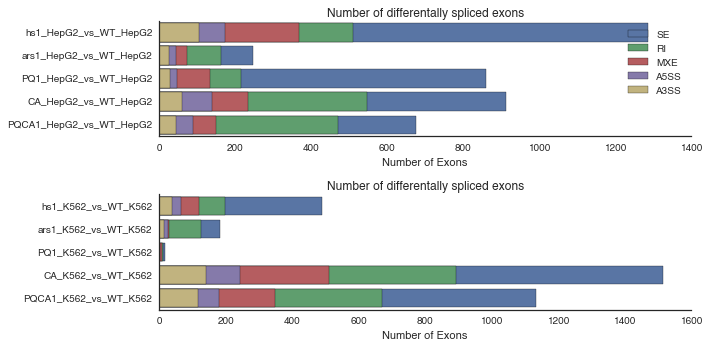

In [17]:
cumsum_num_events = combined_events.cumsum(axis=1)
cumsum_num_events = cumsum_num_events.ix[sort_order]

with dataviz.Figure(os.path.join(heatmap_dir, "number_of_differentally_splice_events_cell_type_split.svg"), figsize=(10, 5)) as fig:
    hepg2_ax = fig.add_subplot(2,1,1)
    k562_ax = fig.add_subplot(2,1,2)
    
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_num_events.columns)):
        hepg2_cumsum = cumsum_num_events.ix[cumsum_num_events.index.map(lambda x: "HepG2" in x)]
        sns.barplot(x=hepg2_cumsum[splice_type], y=hepg2_cumsum.index, color=color, label=splice_type, ax=hepg2_ax)
        hepg2_ax.legend()
        hepg2_ax.set_title("Number of differentally spliced exons")
        hepg2_ax.set_xlabel("Number of Exons")
        sns.despine(ax=hepg2_ax)
        #hepg2_ax.set_xlim(0, 8000)
        #[tick.set_fontsize(6) for tick in hepg2_ax.get_xticklabels()]
        #[tick.set_fontsize(6) for tick in hepg2_ax.get_yticklabels()]
        hepg2_ax.set_ylabel("")
        
        k562_cumsum = cumsum_num_events.ix[~cumsum_num_events.index.map(lambda x: "HepG2" in x)]

        
        sns.barplot(x=k562_cumsum[splice_type], y=k562_cumsum.index, color=color, label=splice_type, ax=k562_ax)
        #k562_ax.legend()
        k562_ax.set_title("Number of differentally spliced exons")
        k562_ax.set_xlabel("Number of Exons")
        sns.despine(ax=k562_ax)
        #k562_ax.set_xlim(0, 8000)
        #[tick.set_fontsize(6) for tick in k562_ax.get_xticklabels()]
        #[tick.set_fontsize(6) for tick in k562_ax.get_yticklabels()]
        k562_ax.set_ylabel("")


Break this out to be directional (included / excluded)
Keep known and cryptic seperate, do mirror analysies
Double check how I define cryptic events (how many reads do I need to call it cryptic or not)
Also whats my fliter of %difference 
What how do my numbers change at different delta psi?
Can show that there is a difference in distribution in fraction of intron retention events for RNAi and Stress datsets

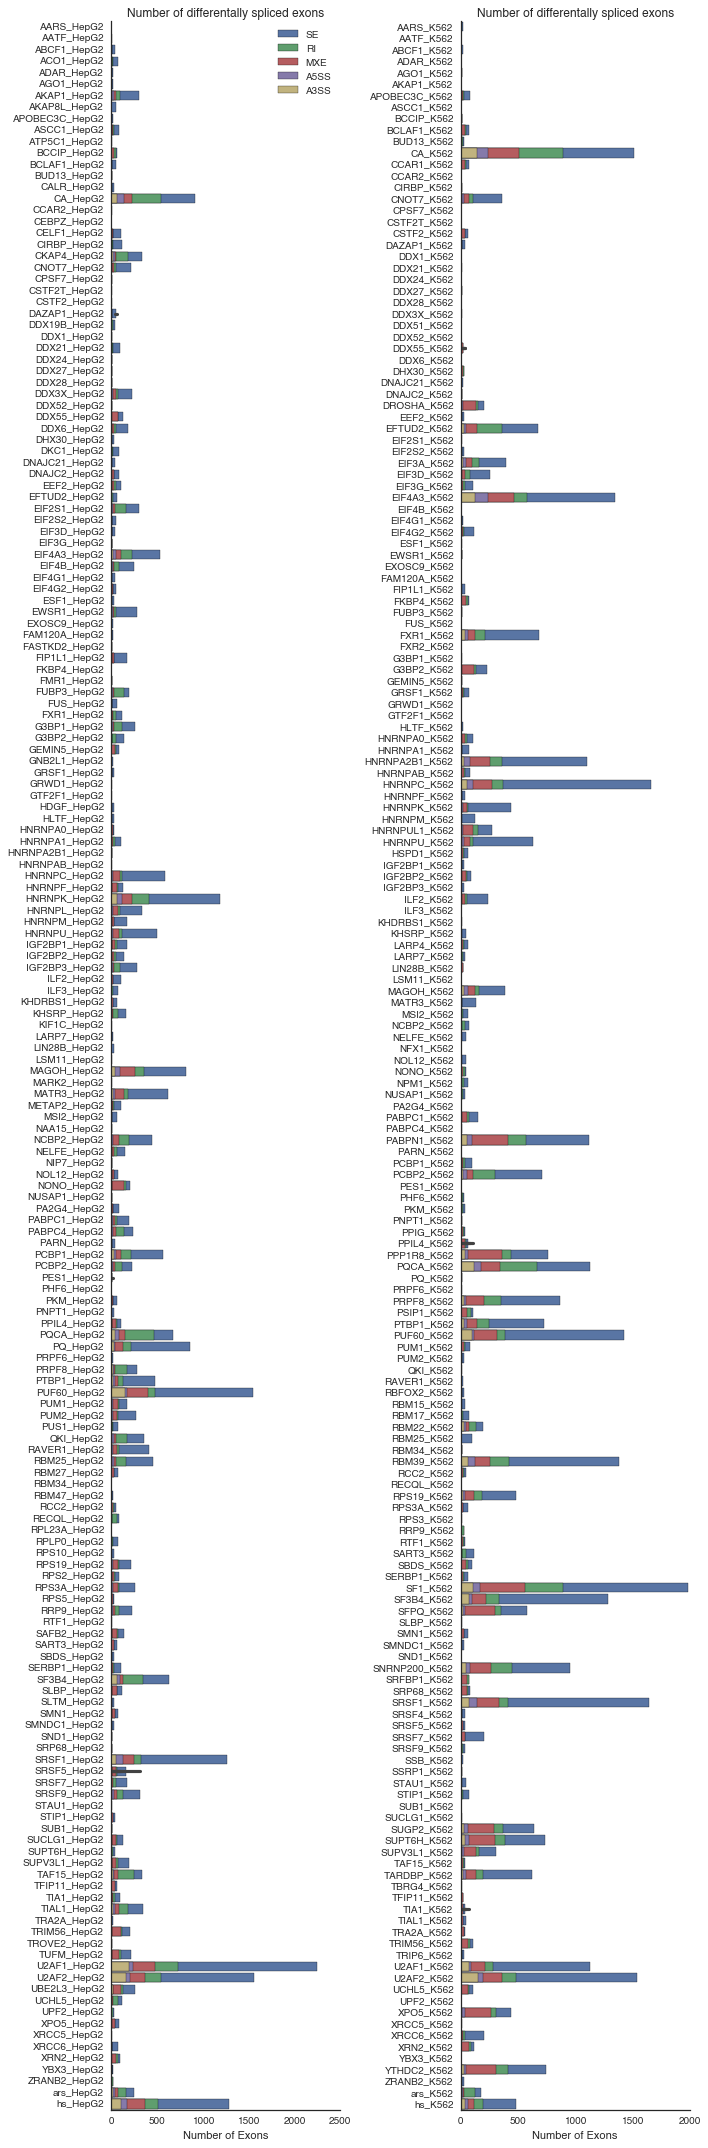

In [18]:
cumsum_num_events = combined_events_encode.cumsum(axis=1)
cumsum_num_events.index = cumsum_num_events.index.map(lambda x: id_to_name[x])
cumsum_num_events = cumsum_num_events.sort_index()

num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_differentally_splice_events_cell_type_split_encode.svg"), figsize=(num_cols * 5, num_rows * 30)) as fig:
    hepg2_ax = fig.add_subplot(num_rows, num_cols, 1)
    k562_ax = fig.add_subplot(num_rows, num_cols, 2)
    
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_num_events.columns)):
        hepg2_cumsum = cumsum_num_events.ix[cumsum_num_events.index.map(lambda x: "HEPG2" in x.upper())]
        sns.barplot(x=hepg2_cumsum[splice_type], y=hepg2_cumsum.index, color=color, label=splice_type, ax=hepg2_ax)
        hepg2_ax.legend()
        hepg2_ax.set_title("Number of differentally spliced exons")
        hepg2_ax.set_xlabel("Number of Exons")
        sns.despine(ax=hepg2_ax)
        #hepg2_ax.set_xlim(0, 8000)
        #[tick.set_fontsize(6) for tick in hepg2_ax.get_xticklabels()]
        #[tick.set_fontsize(6) for tick in hepg2_ax.get_yticklabels()]
        hepg2_ax.set_ylabel("")
        
        k562_cumsum = cumsum_num_events.ix[~cumsum_num_events.index.map(lambda x: "HEPG2" in x.upper())]

        sns.barplot(x=k562_cumsum[splice_type], y=k562_cumsum.index, color=color, label=splice_type, ax=k562_ax)
        #k562_ax.legend()
        k562_ax.set_title("Number of differentally spliced exons")
        k562_ax.set_xlabel("Number of Exons")
        sns.despine(ax=k562_ax)
        #k562_ax.set_xlim(0, 8000)
        #[tick.set_fontsize(6) for tick in k562_ax.get_xticklabels()]
        #[tick.set_fontsize(6) for tick in k562_ax.get_yticklabels()]
        k562_ax.set_ylabel("")

In [19]:
result = defaultdict(list)
for key, value in id_to_name.items():
    result[value].append(key)

In [20]:
for key, value in result.items():
    if len(value)> 1:
        print key, " ".join([item.split("_vs_")[0] for item in value])

FXR2_K562 ENCSR577XBW ENCSR139BIJ
PTBP1_K562 ENCSR239BCO ENCSR527IVX
IGF2BP3_K562 ENCSR302JQA ENCSR481YXD
DDX55_K562 ENCSR331DUD ENCSR856CJK
DAZAP1_HepG2 ENCSR840QFR ENCSR220TBR
SRSF5_HepG2 ENCSR447UCG ENCSR781YNI
TIA1_K562 ENCSR703QFF ENCSR694LKY
PES1_HepG2 ENCSR496ETJ ENCSR912EHP
HNRNPC_K562 ENCSR470PRV ENCSR634KBO
puro_MN AV_GY6_2_puro_1_S44_L007_R1_001 AV_Kin1ALS17_3_puro_S48_L007_R1_001 AV_47d_puro_1_S51_L008_R1_001 AV_CVB_puro_S49_L007_R1_001 AV_ALS17_5_puro_1_S46_L007_R1_001
TARDBP_K562 ENCSR455TNF ENCSR134JRE
PPIL4_K562 ENCSR556FNN ENCSR096BEN ENCSR096BEN
RECQL_K562 ENCSR310VND ENCSR014VQS
HNRNPU_K562 ENCSR732ICL ENCSR047IUS
SF1_K562 ENCSR562CCA ENCSR628JYB
TAF15_K562 ENCSR611ZAL ENCSR031RZS


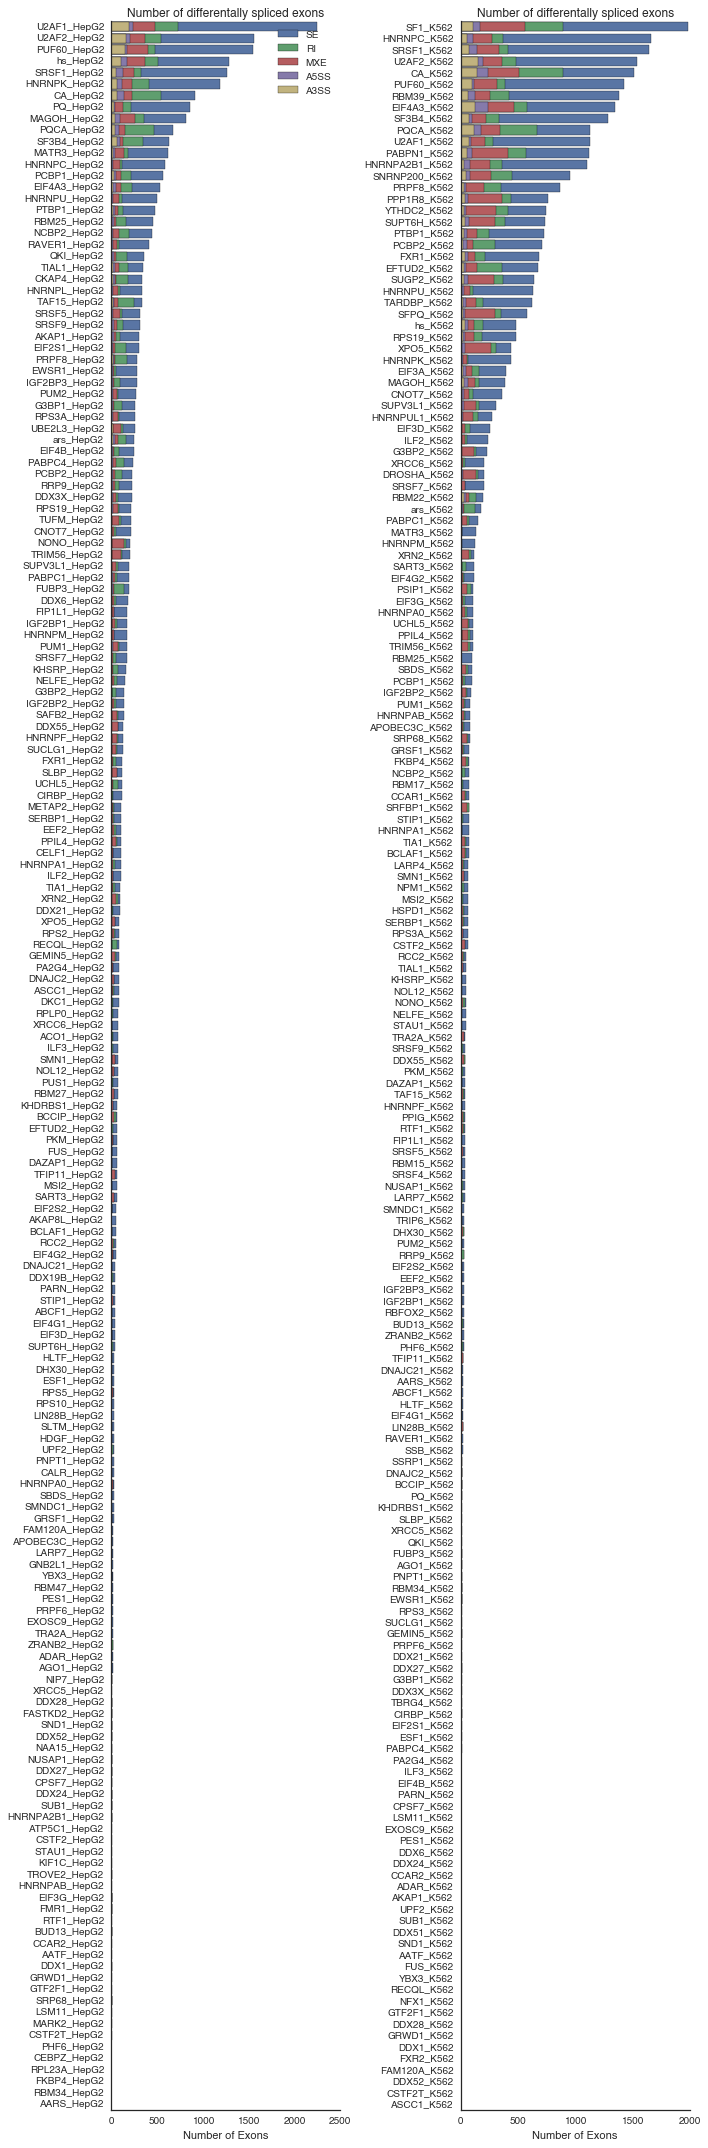

In [21]:
cumsum_num_events = combined_events_encode.cumsum(axis=1)
cumsum_num_events.index = cumsum_num_events.index.map(lambda x: id_to_name[x])
cumsum_num_events = cumsum_num_events.sort_values("SE", ascending=False)
cumsum_num_events = cumsum_num_events.drop("puro_MN")
cumsum_num_events = cumsum_num_events.groupby(level=0).first()
cumsum_num_events = cumsum_num_events.sort_values("SE", ascending=False)

num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_differentally_splice_events_cell_type_split_encode_max_sorted.svg"), figsize=(num_cols * 5, 30)) as fig:
    hepg2_ax = fig.add_subplot(num_rows, num_cols, 1)
    k562_ax = fig.add_subplot(num_rows, num_cols, 2)
    
    hepg2_cumsum = cumsum_num_events.ix[cumsum_num_events.index.map(lambda x: "HEPG2" in x.upper())]
    k562_cumsum = cumsum_num_events.ix[~cumsum_num_events.index.map(lambda x: "HEPG2" in x.upper())]

    for color, splice_type in zip(sns.color_palette(n_colors=5), list(reversed(cumsum_num_events.columns))):
        sns.barplot(x=hepg2_cumsum[splice_type].values, y=hepg2_cumsum.index, color=color, label=splice_type, ax=hepg2_ax)
        hepg2_ax.legend()
        hepg2_ax.set_title("Number of differentally spliced exons")
        hepg2_ax.set_xlabel("Number of Exons")
        sns.despine(ax=hepg2_ax)
        #hepg2_ax.set_xlim(0, 8000)
        hepg2_ax.set_ylabel("")
        

        sns.barplot(x=k562_cumsum[splice_type].values, y=k562_cumsum.index, color=color, label=splice_type, ax=k562_ax)
        #k562_ax.legend()
        k562_ax.set_title("Number of differentally spliced exons")
        k562_ax.set_xlabel("Number of Exons")
        sns.despine(ax=k562_ax)
        #k562_ax.set_xlim(0, 8000)
        k562_ax.set_ylabel("")

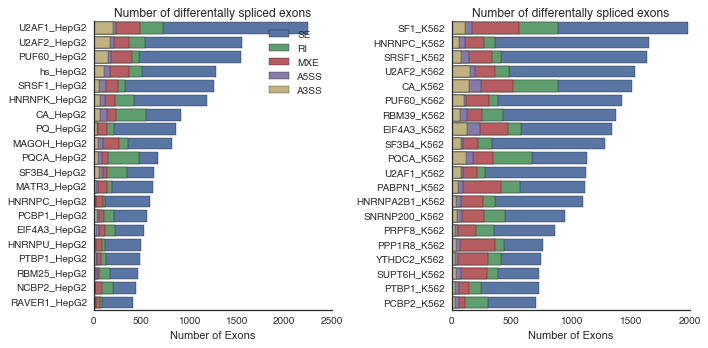

In [22]:
cumsum_num_events = combined_events_encode.cumsum(axis=1)
cumsum_num_events.index = cumsum_num_events.index.map(lambda x: id_to_name[x])
cumsum_num_events = cumsum_num_events.sort_values("SE", ascending=False)
cumsum_num_events = cumsum_num_events.drop("puro_MN")
cumsum_num_events = cumsum_num_events.groupby(level=0).first()
cumsum_num_events = cumsum_num_events.sort_values("SE", ascending=False)

num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_differentally_splice_events_cell_type_split_encode_max_sorted_top_20.svg"), figsize=(num_cols * 5, 5)) as fig:
    hepg2_ax = fig.add_subplot(num_rows, num_cols, 1)
    k562_ax = fig.add_subplot(num_rows, num_cols, 2)
    
    hepg2_cumsum = cumsum_num_events.ix[cumsum_num_events.index.map(lambda x: "HEPG2" in x.upper())].head(n=20)
    k562_cumsum = cumsum_num_events.ix[~cumsum_num_events.index.map(lambda x: "HEPG2" in x.upper())].head(n=20)

    for color, splice_type in zip(sns.color_palette(n_colors=5), list(reversed(cumsum_num_events.columns))):
        sns.barplot(x=hepg2_cumsum[splice_type].values, y=hepg2_cumsum.index, color=color, label=splice_type, ax=hepg2_ax)
        hepg2_ax.legend()
        hepg2_ax.set_title("Number of differentally spliced exons")
        hepg2_ax.set_xlabel("Number of Exons")
        sns.despine(ax=hepg2_ax)
        #hepg2_ax.set_xlim(0, 8000)
        hepg2_ax.set_ylabel("")
        

        sns.barplot(x=k562_cumsum[splice_type].values, y=k562_cumsum.index, color=color, label=splice_type, ax=k562_ax)
        #k562_ax.legend()
        k562_ax.set_title("Number of differentally spliced exons")
        k562_ax.set_xlabel("Number of Exons")
        sns.despine(ax=k562_ax)
        #k562_ax.set_xlim(0, 8000)
        k562_ax.set_ylabel("")

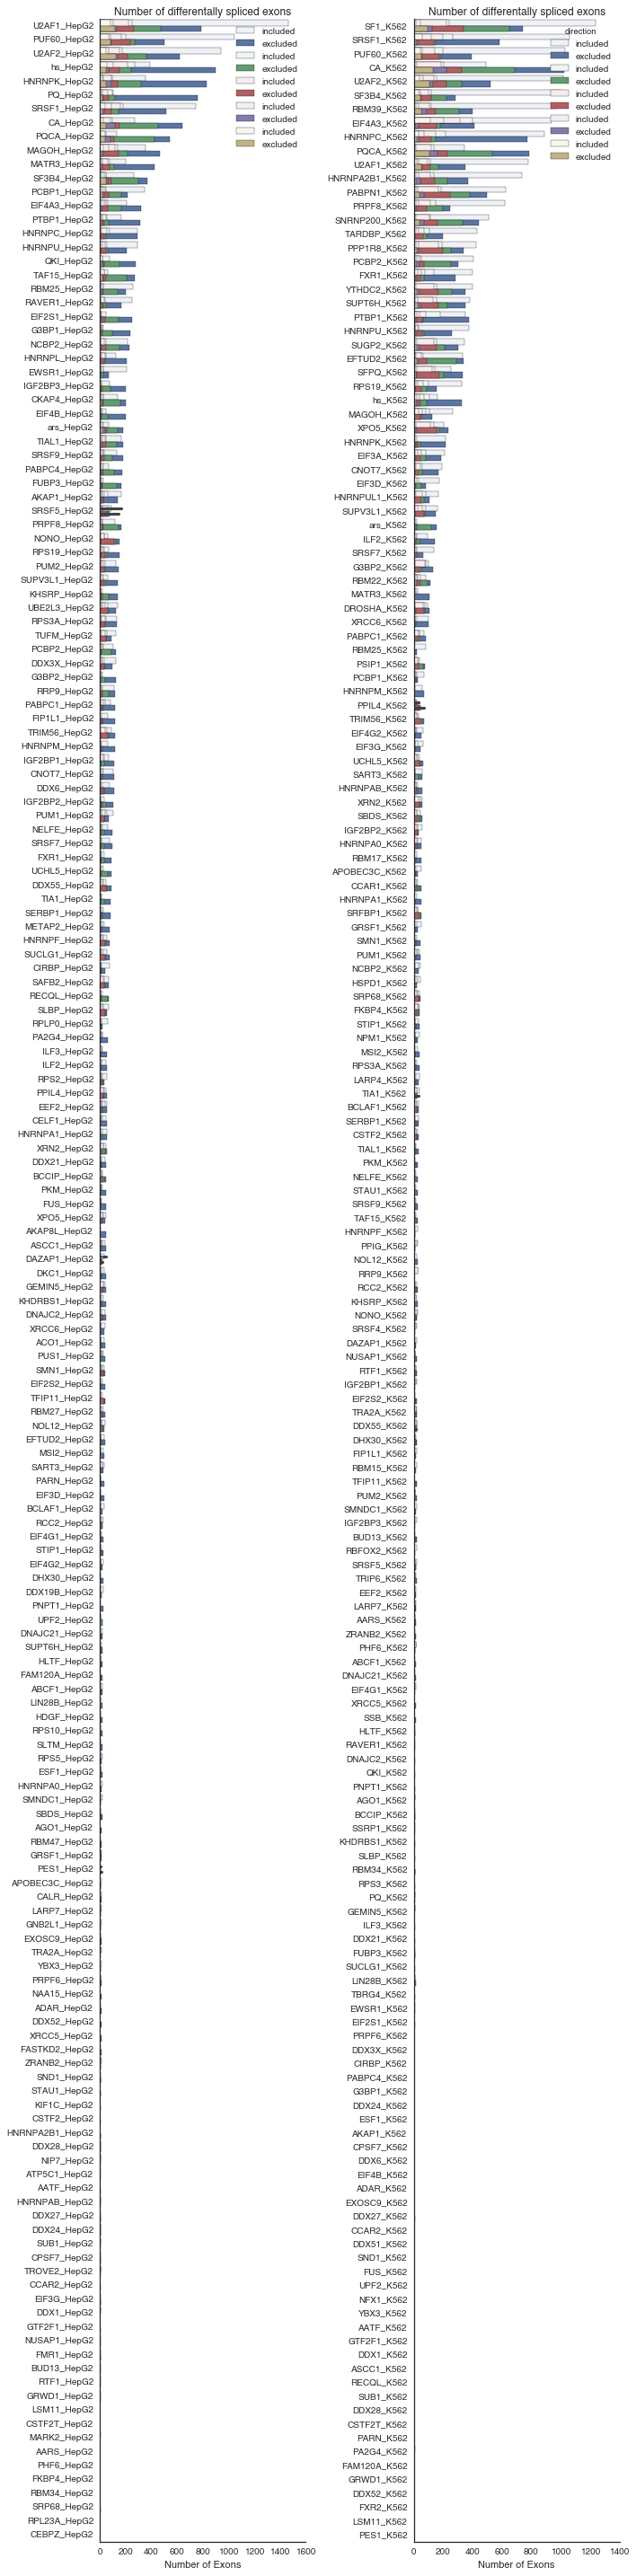

In [23]:
both_directions = num_events_encode.stack()

cumsum_num_events = both_directions.cumsum(axis=1)
cumsum_num_events['name'] = cumsum_num_events.index.map(lambda x: id_to_name[x[0]])
cumsum_num_events['direction'] = cumsum_num_events.index.get_level_values(level=1)
cumsum_num_events = cumsum_num_events.sort_values("SE", ascending=False)
cumsum_num_events = cumsum_num_events[cumsum_num_events.name != "puro_MN"]
#cumsum_num_events = cumsum_num_events.groupby(level=0).first()
#cumsum_num_events = cumsum_num_events.sort_values("SE", ascending=False)

num_rows = 1
num_cols = 2


with dataviz.Figure(os.path.join(heatmap_dir, "number_of_differentally_splice_events_cell_type_split_encode_max_sorted_top_20.svg"), figsize=(num_cols * 5, 40)) as fig:
    hepg2_ax = fig.add_subplot(num_rows, num_cols, 1)
    k562_ax = fig.add_subplot(num_rows, num_cols, 2)
    
    hepg2_cumsum = cumsum_num_events.ix[cumsum_num_events['name'].map(lambda x: "HEPG2" in x.upper())]
    k562_cumsum = cumsum_num_events.ix[~cumsum_num_events['name'].map(lambda x: "HEPG2" in x.upper())]
    
    for color, splice_type in zip(sns.color_palette(n_colors=5), list(reversed(both_directions.columns))):
        sns.barplot(x=splice_type, y="name", hue="direction", data=hepg2_cumsum, color=color, ax=hepg2_ax)
        hepg2_ax.legend()
        hepg2_ax.set_title("Number of differentally spliced exons")
        hepg2_ax.set_xlabel("Number of Exons")
        sns.despine(ax=hepg2_ax)
        #hepg2_ax.set_xlim(0, 8000)
        hepg2_ax.set_ylabel("")
        

        sns.barplot(x=splice_type, y="name", hue="direction", data=k562_cumsum, color=color, ax=k562_ax)
        #k562_ax.legend()
        k562_ax.set_title("Number of differentally spliced exons")
        k562_ax.set_xlabel("Number of Exons")
        sns.despine(ax=k562_ax)
        #k562_ax.set_xlim(0, 8000)
        k562_ax.set_ylabel("")

How about sorting them only overlapping RBPs

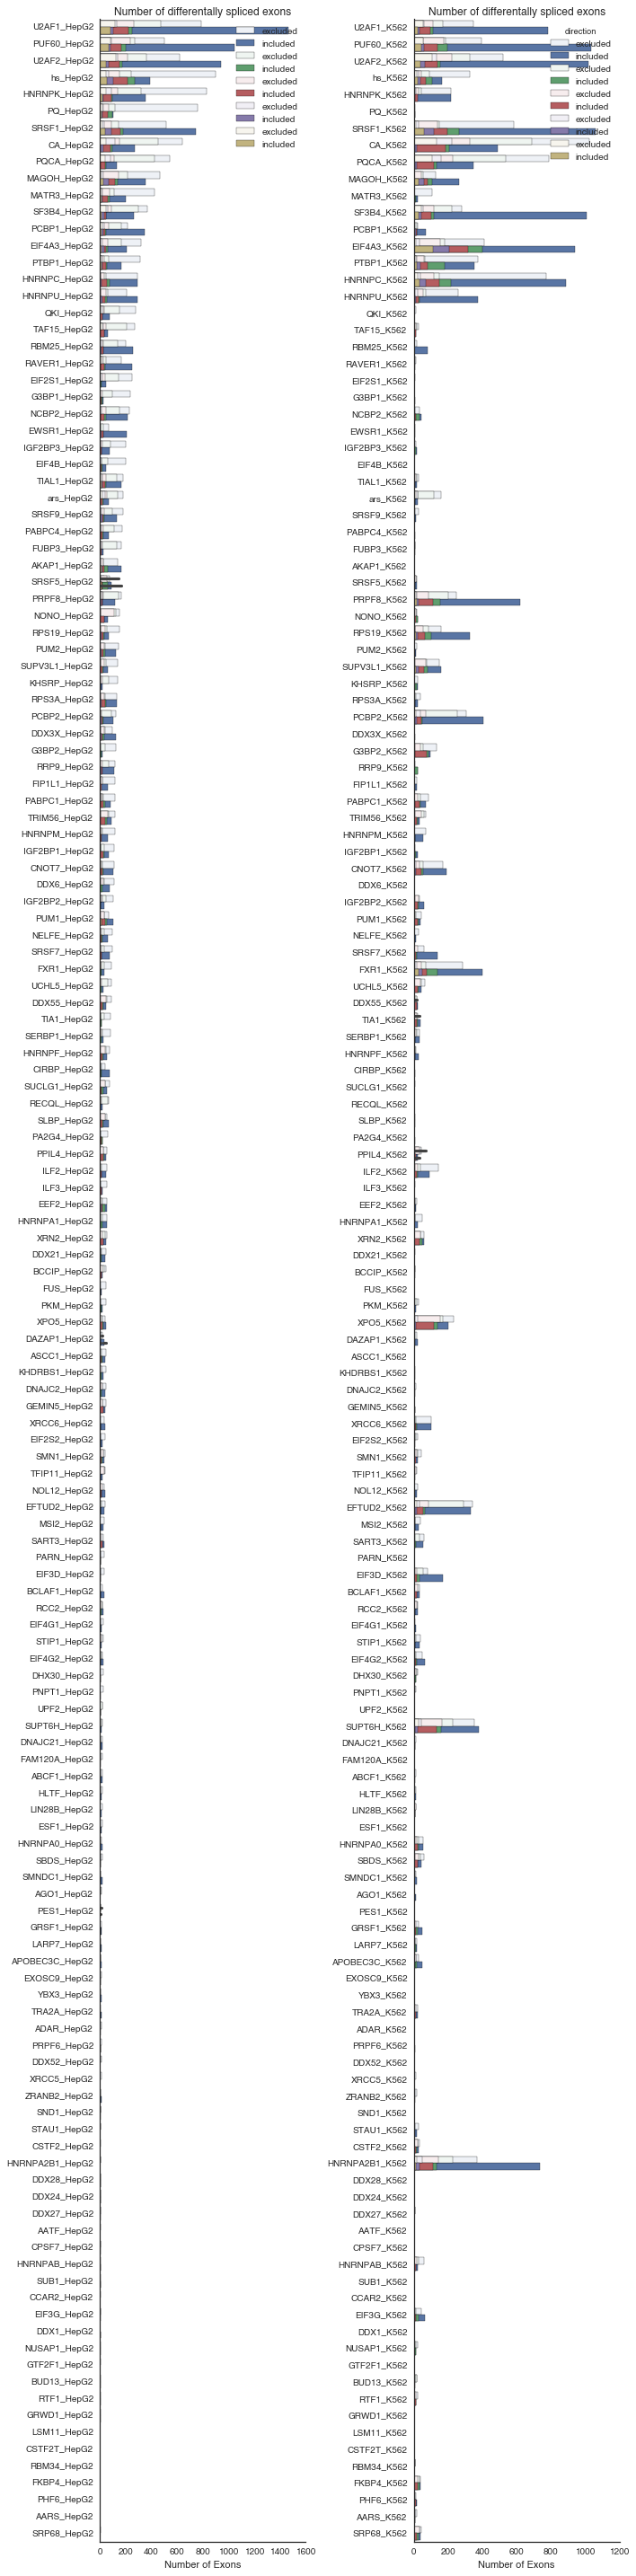

In [24]:
both_directions = num_events_encode.stack()

cumsum_num_events = both_directions.cumsum(axis=1)
cumsum_num_events['name'] = cumsum_num_events.index.map(lambda x: id_to_name[x[0]])
cumsum_num_events['direction'] = cumsum_num_events.index.get_level_values(level=1)
#cumsum_num_events = cumsum_num_events.groupby(level=0).first()
#cumsum_num_events = cumsum_num_events.sort_values("SE", ascending=False)
cumsum_num_events['rbp'] = cumsum_num_events.name.map(lambda x: x.split("_")[0])
cumsum_num_events['cell_type'] = cumsum_num_events.name.map(lambda x: x.split("_")[1])

cumsum_num_events = cumsum_num_events.sort_values("rbp", ascending=False)
cumsum_num_events = cumsum_num_events[cumsum_num_events.name != "puro_MN"]

foo = pd.Series(Counter([item.split("_")[0] for item in set(cumsum_num_events.name)]))
foo = foo[foo >= 2]

cumsum_num_events = cumsum_num_events[cumsum_num_events.rbp.isin(foo.index)]

rbp_order = cumsum_num_events[cumsum_num_events.cell_type == "HepG2"].sort_values("SE", ascending=False).groupby("rbp").first().sort_values("SE", ascending=False).index
sorted_order = {rbp: rbp_rank for rbp_rank, rbp in enumerate(rbp_order)}
cumsum_num_events['rbp_order'] = cumsum_num_events.rbp.map(lambda x: sorted_order[x])
cumsum_num_events = cumsum_num_events.sort_values(["rbp_order", "cell_type"])

num_rows = 1
num_cols = 2


with dataviz.Figure(os.path.join(heatmap_dir, "number_of_differentally_splice_events_cell_type_split_encode_max_sorted_top_20.svg"), figsize=(num_cols * 5, 40)) as fig:
    hepg2_ax = fig.add_subplot(num_rows, num_cols, 1)
    k562_ax = fig.add_subplot(num_rows, num_cols, 2)
    
    hepg2_cumsum = cumsum_num_events.ix[cumsum_num_events['name'].map(lambda x: "HEPG2" in x.upper())]
    k562_cumsum = cumsum_num_events.ix[~cumsum_num_events['name'].map(lambda x: "HEPG2" in x.upper())]
    
    for color, splice_type in zip(sns.color_palette(n_colors=5), list(reversed(both_directions.columns))):
        sns.barplot(x=splice_type, y="name", hue="direction", data=hepg2_cumsum, color=color, ax=hepg2_ax)
        hepg2_ax.legend()
        hepg2_ax.set_title("Number of differentally spliced exons")
        hepg2_ax.set_xlabel("Number of Exons")
        sns.despine(ax=hepg2_ax)
        #hepg2_ax.set_xlim(0, 8000)
        hepg2_ax.set_ylabel("")
        

        sns.barplot(x=splice_type, y="name", hue="direction", data=k562_cumsum, color=color, ax=k562_ax)
        #k562_ax.legend()
        k562_ax.set_title("Number of differentally spliced exons")
        k562_ax.set_xlabel("Number of Exons")
        sns.despine(ax=k562_ax)
        #k562_ax.set_xlim(0, 8000)
        k562_ax.set_ylabel("")

Get KD info from brent
Remake this sorted by number of exons
call out cell type specific dependency 

In [25]:
fraction_combined_events = combined_events.div(combined_events.sum(axis=1), axis=0)
fraction_combined_events_encode = combined_events_encode.div(combined_events_encode.sum(axis=1), axis=0)

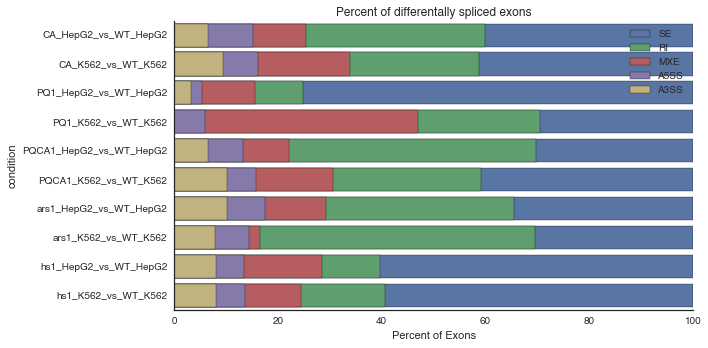

In [26]:
cumsum_fraction_combined_events = fraction_combined_events.cumsum(axis=1) * 100

with dataviz.Figure(os.path.join(heatmap_dir, "fraction_of_differentally_splice_events.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_fraction_combined_events.columns)):
        sns.barplot(x=cumsum_fraction_combined_events[splice_type], y=cumsum_fraction_combined_events.index, color=color, label=splice_type, ax=ax)
        ax.legend()
        ax.set_title("Percent of differentally spliced exons")
        ax.set_xlabel("Percent of Exons")
        sns.despine(ax=ax)

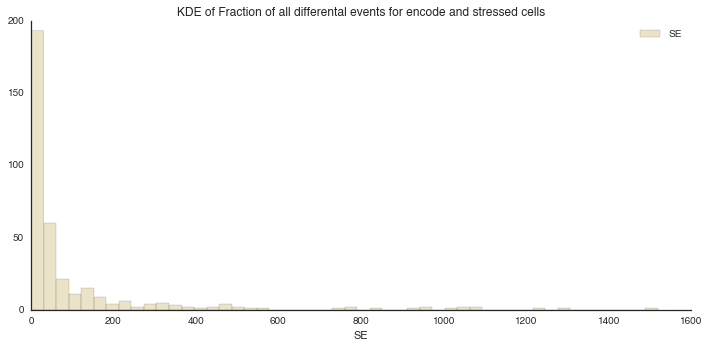

In [27]:
with dataviz.Figure(os.path.join(heatmap_dir, "encode_all_se_distribution.svg"), figsize=(10, 5)) as fig:
 
    ax = fig.add_subplot(1,1,1)
    sns.distplot(combined_events_encode.ix[combined_events_encode.index.difference(sort_order)]['SE'].fillna(0), 
                 hist=True, norm_hist=False, kde=False, color=color, label='SE', ax=ax)
    ax.legend()
    ax.set_title("KDE of Fraction of all differental events for encode and stressed cells")
    ax.set_xlim(0,)
    sns.despine(ax=ax)

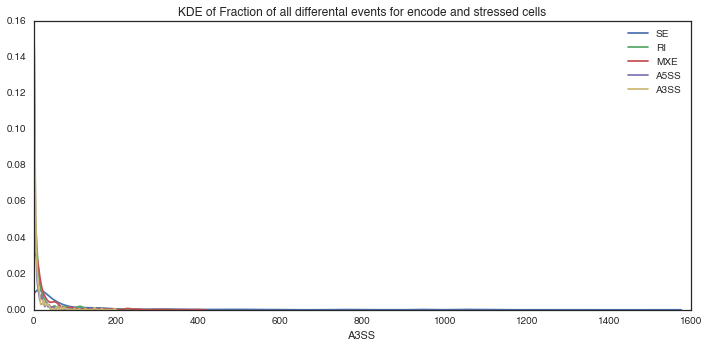

In [28]:
with dataviz.Figure(os.path.join(heatmap_dir, "stress_vs_encode_all_distribution.svg"), figsize=(10, 5)) as fig:
 
    ax = fig.add_subplot(1,1,1)
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(both_directions.columns)):
        sns.distplot(combined_events_encode.ix[combined_events_encode.index.difference(sort_order)][splice_type].fillna(0), hist=False, color=color, label=splice_type, ax=ax)
    ax.legend()
    ax.set_title("KDE of Fraction of all differental events for encode and stressed cells")
    ax.set_xlim(0,)
    

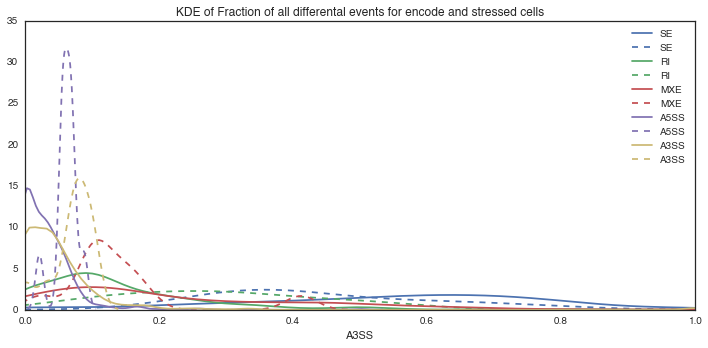

In [29]:
with dataviz.Figure(os.path.join(heatmap_dir, "stress_vs_encode_all_distribution.svg"), figsize=(10, 5)) as fig:
 
    ax = fig.add_subplot(1,1,1)
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(both_directions.columns)):
 
        sns.distplot(fraction_combined_events_encode[splice_type].fillna(0), hist=False, color=color, label=splice_type, ax=ax)
        sns.distplot(fraction_combined_events_encode.ix[sort_order][splice_type].fillna(0), hist=False, color=color, kde_kws ={'linestyle': "--"}, label=splice_type, ax=ax)
    ax.legend()
    ax.set_title("KDE of Fraction of all differental events for encode and stressed cells")
    ax.set_xlim(0,1)

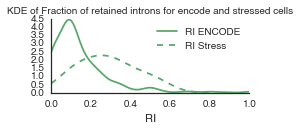

In [30]:
with dataviz.Figure(os.path.join(heatmap_dir, "stress_vs_encode_ri_distribution.svg"), figsize=(4, 2)) as fig:
 
    ax = fig.add_subplot(1,1,1)
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(both_directions.columns)):
        if splice_type != "RI":
            continue
        sns.distplot(fraction_combined_events_encode[splice_type].fillna(0), hist=False, color=color, label=splice_type + " ENCODE", ax=ax)
        sns.distplot(fraction_combined_events_encode.ix[sort_order][splice_type].fillna(0), hist=False, color=color, kde_kws ={'linestyle': "--"}, label=splice_type + " Stress", ax=ax)
        ax.legend()
        ax.set_xlim(0,1)
        ax.set_title("KDE of Fraction of retained introns for encode and stressed cells", fontsize=10)
        sns.despine(ax=ax)

This figure sucks plot encode distribution and points with labels for the stress, do a ?binomial? test to see if the point falls outside of expectation

In [31]:
fraction_cryptic_events = se_sig_stress_events[se_sig_stress_events.is_cryptic].groupby(level=["direction", "condition"]).count().GeneID.unstack().T / se_sig_stress_events.groupby(level=["direction", "condition"]).count().GeneID.unstack().T
fraction_cryptic_events

direction                excluded  included
condition                                  
CA_HepG2_vs_WT_HepG2     0.510753  0.244444
CA_K562_vs_WT_K562       0.533923  0.249123
PQ1_HepG2_vs_WT_HepG2    0.354788  0.300000
PQ1_K562_vs_WT_K562      1.000000  0.500000
PQCA1_HepG2_vs_WT_HepG2  0.491379  0.306818
PQCA1_K562_vs_WT_K562    0.525896  0.221698
ars1_HepG2_vs_WT_HepG2   0.545455  0.268293
ars1_K562_vs_WT_K562     0.564103  0.375000
hs1_HepG2_vs_WT_HepG2    0.624620  0.250000
hs1_K562_vs_WT_K562      0.465812  0.321429

In [32]:
se_sig_stress_events['direction'] = se_sig_stress_events.index.get_level_values(level=0)

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


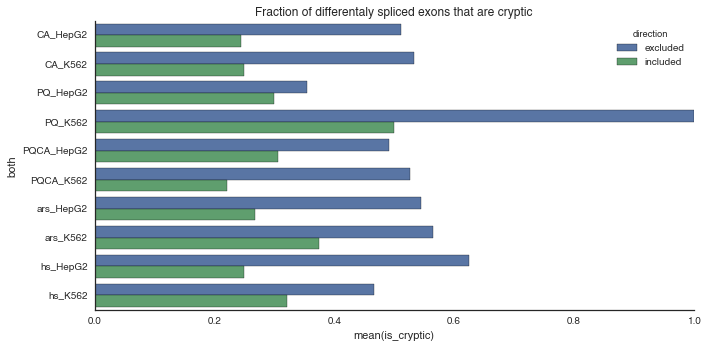

In [33]:
#fraction of events that are bound proximally by RBP
with dataviz.Figure(os.path.join(heatmap_dir, "fraction_cryptic_events_stress.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Fraction of differentaly spliced exons that are cryptic")
 
    sns.barplot(x="is_cryptic", y="both", hue="direction", data=se_sig_stress_events, ci=False,
               ax=ax)
    sns.despine(ax=ax)

Check cryptic exons make sure they have splicing signal GT AG

#look for stress response genes in the different stressors
chaperones for PQ

# ok now for the hard part, figure out how to get co-occuring splicing events

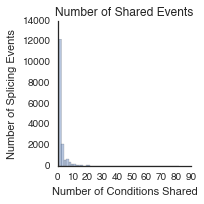

In [34]:
all_sig_se_events = all_sig_events.xs("SE").dropna(how="all", axis=1)

#fraction of events that are bound proximally by RBP
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_shared_events.svg"), figsize=(3, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    sns.distplot(all_sig_se_events.groupby("group_id").count().FDR, kde=False, norm_hist=False, ax=ax)
    sns.despine()
    ax.set_title("Number of Shared Events")
    ax.set_ylabel("Number of Splicing Events")
    ax.set_xlabel("Number of Conditions Shared")

In [35]:
# Counter(se_events.groupby("group_id").count().FDR)
# #There aren't a bunch of conserved splicing events between everything, but there are a bunch of pairwise events

#How many splicing events are shared between each experiment?

In [36]:
#Jaccard and regular overlap Calculation
#Columns are the denominator
jaccard_matrix = defaultdict(dict)
fraction_matrix = defaultdict(dict)
shared_matrix = defaultdict(dict)

se_swapped = all_sig_se_events.swaplevel(0,1)
for condition_1, condition_2 in itertools.product(se_swapped.index.levels[0], se_swapped.index.levels[0]):
    overlapped = pd.concat([se_swapped.ix[condition_1], se_swapped.ix[condition_2]])
    shared_count = (overlapped.groupby("group_id").count() >= 2).sum().FDR

    jaccard_matrix[condition_1][condition_2] = shared_count / (len(overlapped.groupby("group_id").count()) * 1.0)
    fraction_matrix[condition_1][condition_2] = shared_count / (len(se_swapped.ix[condition_1]) * 1.0)
    shared_matrix[condition_1][condition_2] = shared_count
    
jaccard_matrix = pd.DataFrame(jaccard_matrix)
jaccard_matrix[jaccard_matrix.applymap(np.isneginf)] = 0
jaccard_matrix[jaccard_matrix.applymap(np.isinf)] = 0
jaccard_matrix = jaccard_matrix.fillna(0)

fraction_matrix = pd.DataFrame(fraction_matrix)
fraction_matrix[fraction_matrix.applymap(np.isneginf)] = 0
fraction_matrix[fraction_matrix.applymap(np.isinf)] = 0
fraction_matrix = fraction_matrix.fillna(0)

shared_matrix = pd.DataFrame(shared_matrix)
shared_matrix[shared_matrix.applymap(np.isneginf)] = 0
shared_matrix[shared_matrix.applymap(np.isinf)] = 0
shared_matrix = shared_matrix.fillna(0)

In [37]:
jaccard_matrix.index = jaccard_matrix.index.map(lambda x: id_to_name[x])
jaccard_matrix.columns = jaccard_matrix.columns.map(lambda x: id_to_name[x])

fraction_matrix.index = fraction_matrix.index.map(lambda x: id_to_name[x])
fraction_matrix.columns = fraction_matrix.columns.map(lambda x: id_to_name[x])

shared_matrix.index = shared_matrix.index.map(lambda x: id_to_name[x])
shared_matrix.columns = shared_matrix.columns.map(lambda x: id_to_name[x])

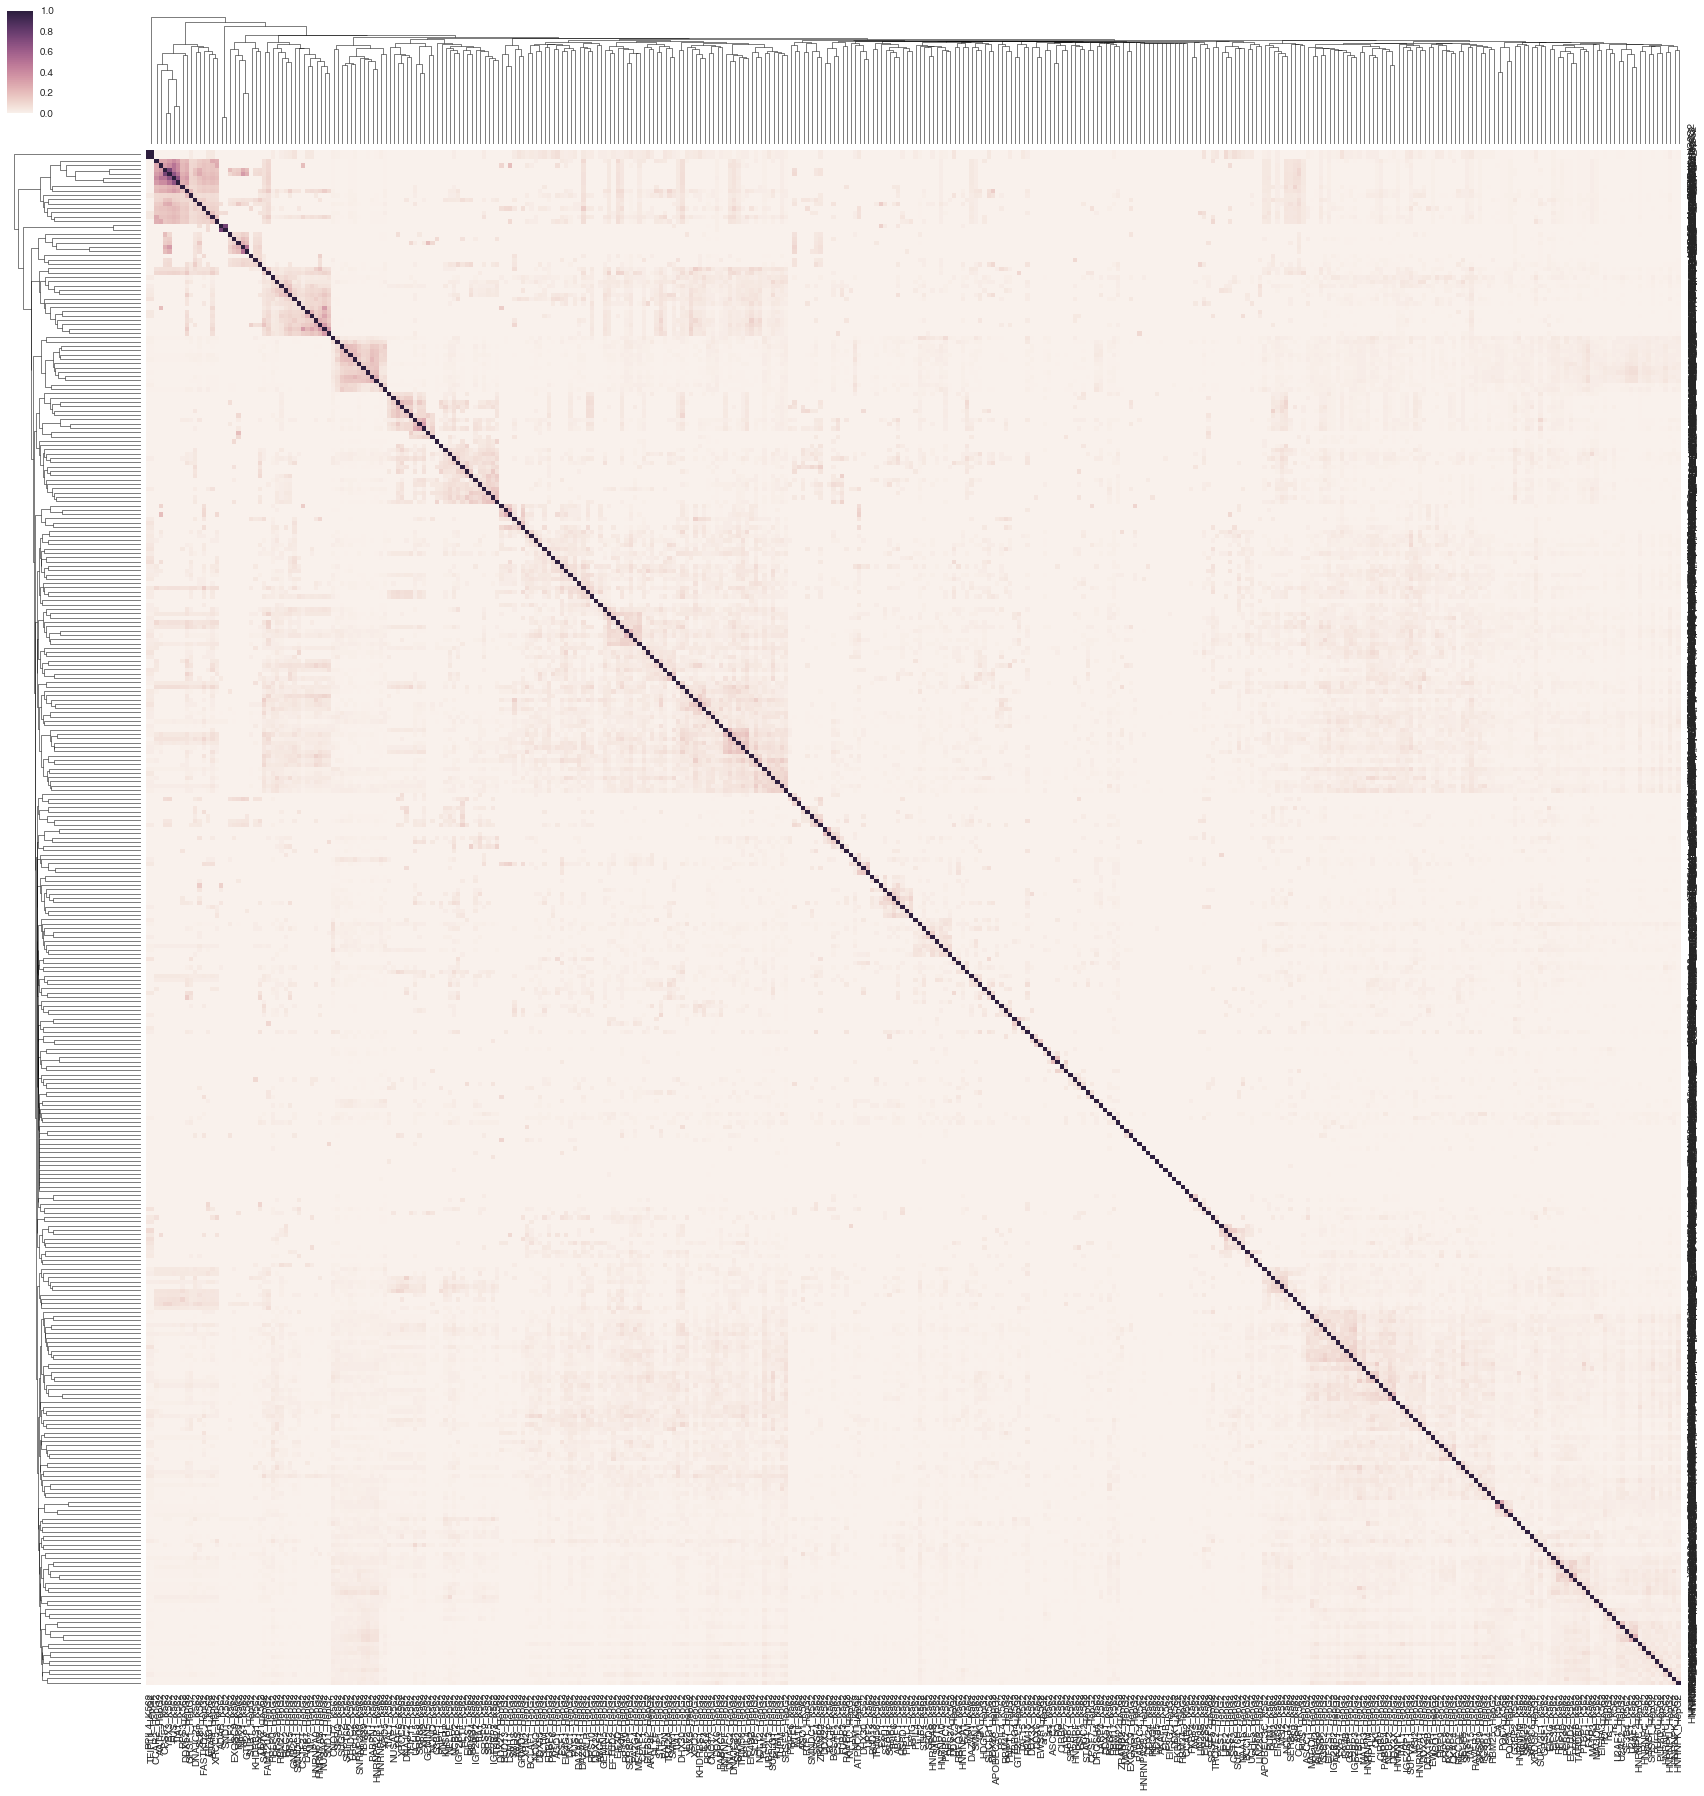

In [38]:
sns.clustermap(jaccard_matrix.loc[jaccard_matrix.sum(axis=0) != 0,jaccard_matrix.sum(axis=1) != 0], 
            figsize=(30,30)
           )

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "jaccard_of_shared_events.svg"))
fig.savefig(os.path.join(heatmap_dir, "jaccard_of_shared_events.pdf"))  

In [39]:
stress_ids = ["CA_HepG2", "CA_K562", "PQ_HepG2", "PQ_K562", "PQCA_HepG2", "PQCA_K562", "ars_HepG2", "ars_K562", 
              "hs_HepG2", "hs_K562",]

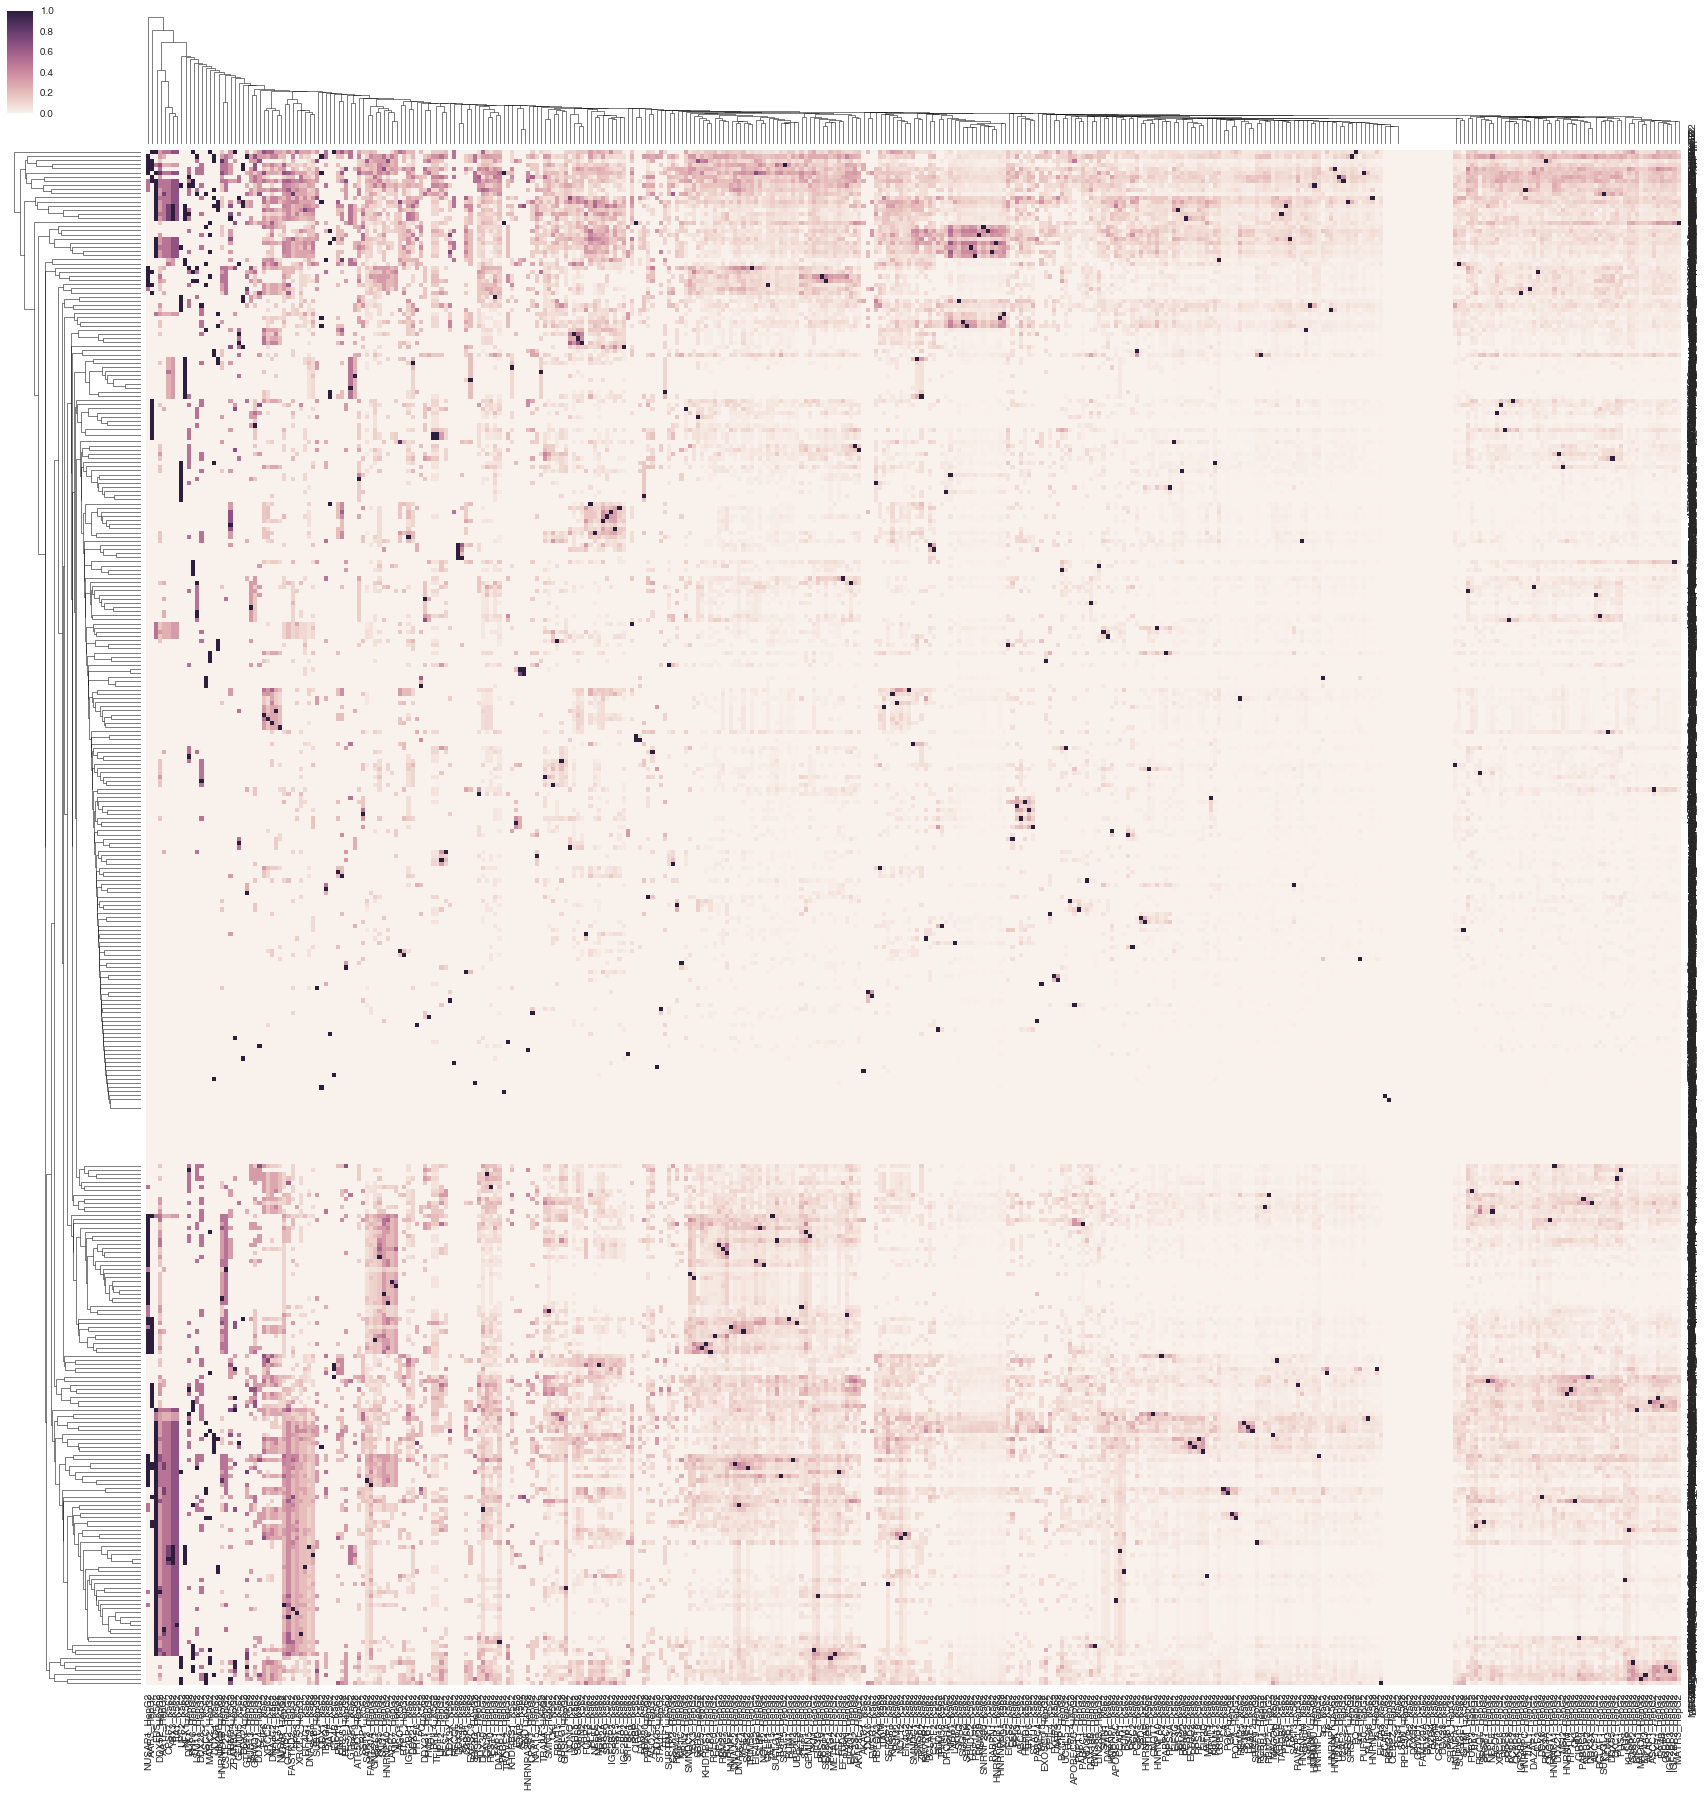

In [40]:
sns.clustermap(fraction_matrix, figsize=(30,30))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "fraction_of_shared_events.svg"))
fig.savefig(os.path.join(heatmap_dir, "fraction_of_shared_events.pdf"))  

In [41]:
fraction_matrix.ix[stress_ids]

CA_HepG2   CA_K562  DDX3X_K562  DNAJC2_HepG2  NFX1_K562  \
CA_HepG2    1.000000  0.104167         0.0          0.04        0.0   
CA_K562     0.177596  1.000000         0.0          0.08        0.0   
PQ_HepG2    0.120219  0.049679         0.0          0.14        0.0   
PQ_K562     0.000000  0.004808         0.0          0.00        0.0   
PQCA_HepG2  0.232240  0.057692         0.0          0.04        0.0   
PQCA_K562   0.144809  0.389423         0.0          0.06        0.0   
ars_HepG2   0.002732  0.011218         0.0          0.00        0.0   
ars_K562    0.000000  0.014423         0.0          0.00        0.0   
hs_HepG2    0.076503  0.038462         0.0          0.08        0.0   
hs_K562     0.021858  0.032051         0.0          0.02        0.0   

            FXR1_HepG2  HLTF_HepG2  SART3_HepG2  APOBEC3C_HepG2  AKAP1_HepG2  \
CA_HepG2      0.078947    0.111111     0.071429        0.000000     0.023256   
CA_K562       0.039474    0.166667     0.142857        0.000000     0.023256   
PQ_HepG2      0.250000    0.166667     0.178571        0.058824     0.079070   
PQ_K562       0.000000    0.000000     0.000000        0.000000     0.000000   
PQCA_HepG2    0.039474    0.000000     0.071429        0.000000     0.009302   
PQCA_K562     0.039474    0.000000     0.107143        0.000000     0.013953   
ars_HepG2     0.000000    0.000000     0.000000        0.000000     0.013953   
ars_K562      0.013158    0.000000     0.000000        0.000000     0.004651   
hs_HepG2      0.118421    0.000000     0.071429        0.058824     0.027907   
hs_K562       0.052632    0.000000     0.071429        0.000000     0.009302   

              ...     PRPF8_HepG2  TAF15_HepG2  PQ_HepG2  PQ_K562  PQCA_HepG2  \
CA_HepG2      ...        0.025862     0.058824  0.068006      0.0    0.416667   
CA_K562       ...        0.008621     0.047059  0.047913      0.6    0.176471   
PQ_HepG2      ...        0.017241     0.070588  1.000000      0.2    0.176471   
PQ_K562       ...        0.000000     0.000000  0.001546      1.0    0.004902   
PQCA_HepG2    ...        0.008621     0.011765  0.055641      0.2    1.000000   
PQCA_K562     ...        0.008621     0.094118  0.046368      0.4    0.186275   
ars_HepG2     ...        0.008621     0.035294  0.009274      0.0    0.024510   
ars_K562      ...        0.000000     0.023529  0.001546      0.6    0.009804   
hs_HepG2      ...        0.025862     0.011765  0.163833      0.0    0.088235   
hs_K562       ...        0.017241     0.023529  0.069552      0.2    0.034314   

            PQCA_K562  ars_HepG2  ars_K562  hs_HepG2   hs_K562  
CA_HepG2     0.114471   0.011765  0.000000  0.035990  0.027586  
CA_K562      0.524838   0.082353  0.163636  0.030848  0.068966  
PQ_HepG2     0.064795   0.070588  0.018182  0.136247  0.155172  
PQ_K562      0.004320   0.000000  0.054545  0.000000  0.003448  
PQCA_HepG2   0.082073   0.058824  0.036364  0.023136  0.024138  
PQCA_K562    1.000000   0.070588  0.200000  0.025707  0.041379  
ars_HepG2    0.012959   1.000000  0.163636  0.029563  0.013793  
ars_K562     0.023758   0.105882  1.000000  0.011568  0.010345  
hs_HepG2     0.043197   0.270588  0.163636  1.000000  0.331034  
hs_K562      0.025918   0.047059  0.054545  0.123393  1.000000  

[10 rows x 371 columns]

In [42]:
fraction_matrix

CA_HepG2   CA_K562  DDX3X_K562  DNAJC2_HepG2  NFX1_K562  \
CA_HepG2        1.000000  0.104167    0.000000          0.04        0.0   
CA_K562         0.177596  1.000000    0.000000          0.08        0.0   
DDX3X_K562      0.000000  0.000000    1.000000          0.00        0.0   
DNAJC2_HepG2    0.005464  0.006410    0.000000          1.00        0.0   
NFX1_K562       0.000000  0.000000    0.000000          0.00        1.0   
FXR1_HepG2      0.016393  0.004808    0.000000          0.06        0.0   
HLTF_HepG2      0.005464  0.004808    0.000000          0.02        0.0   
SART3_HepG2     0.005464  0.006410    0.000000          0.14        0.0   
APOBEC3C_HepG2  0.000000  0.000000    0.000000          0.00        0.0   
AKAP1_HepG2     0.013661  0.008013    0.000000          0.16        0.0   
SRSF7_HepG2     0.010929  0.008013    0.000000          0.08        0.0   
KHDRBS1_K562    0.000000  0.000000    0.000000          0.00        1.0   
PCBP2_HepG2     0.024590  0.003205    0.000000          0.10        0.0   
PA2G4_HepG2     0.010929  0.012821    0.000000          0.02        0.0   
DDX51_K562      0.000000  0.000000    0.000000          0.00        0.0   
NCBP2_HepG2     0.030055  0.016026    0.000000          0.08        0.0   
TRA2A_HepG2     0.002732  0.004808    0.000000          0.00        0.0   
HNRNPUL1_K562   0.008197  0.014423    0.142857          0.00        0.0   
EIF4G2_K562     0.013661  0.012821    0.000000          0.04        0.0   
CALR_HepG2      0.008197  0.003205    0.000000          0.00        0.0   
SUB1_K562       0.000000  0.000000    0.000000          0.00        0.0   
PABPC4_K562     0.000000  0.000000    0.000000          0.00        0.0   
HNRNPU_K562     0.027322  0.036859    0.428571          0.00        0.0   
FAM120A_HepG2   0.013661  0.004808    0.000000          0.10        0.0   
HNRNPA1_K562    0.000000  0.003205    0.142857          0.00        0.0   
HNRNPC_HepG2    0.051913  0.030449    0.000000          0.38        0.0   
CIRBP_K562      0.000000  0.000000    0.000000          0.00        0.0   
TIA1_HepG2      0.013661  0.009615    0.000000          0.08        0.0   
ESF1_HepG2      0.000000  0.001603    0.000000          0.00        0.0   
PTBP1_HepG2     0.030055  0.022436    0.000000          0.10        0.0   
...                  ...       ...         ...           ...        ...   
G3BP2_HepG2     0.013661  0.016026    0.000000          0.04        0.0   
PUM1_HepG2      0.005464  0.008013    0.000000          0.12        0.0   
TROVE2_HepG2    0.000000  0.000000    0.000000          0.00        0.0   
RBM22_K562      0.002732  0.008013    0.000000          0.02        0.0   
IGF2BP2_K562    0.000000  0.003205    0.000000          0.00        0.0   
SART3_K562      0.000000  0.014423    0.000000          0.00        0.0   
EIF4A3_HepG2    0.024590  0.020833    0.000000          0.02        0.0   
HLTF_K562       0.000000  0.000000    0.000000          0.00        0.0   
DDX21_K562      0.000000  0.001603    0.000000          0.00        1.0   
EIF4A3_K562     0.030055  0.043269    0.000000          0.02        0.0   
APOBEC3C_K562   0.008197  0.004808    0.000000          0.04        0.0   
DDX55_HepG2     0.010929  0.004808    0.000000          0.02        0.0   
AATF_K562       0.000000  0.000000    0.000000          0.00        0.0   
PKM_K562        0.005464  0.006410    0.000000          0.00        0.0   
CCAR2_K562      0.000000  0.000000    0.000000          0.00        0.0   
METAP2_HepG2    0.019126  0.016026    0.000000          0.08        0.0   
HNRNPM_HepG2    0.016393  0.004808    0.000000          0.14        0.0   
SUPV3L1_HepG2   0.019126  0.012821    0.000000          0.14        0.0   
SMNDC1_HepG2    0.002732  0.000000    0.000000          0.04        0.0   
SUB1_HepG2      0.000000  0.000000    0.000000          0.02        0.0   
PRPF8_HepG2     0.008197  0.001603    0.000000          0.02        0.0   
TAF15_HepG2     0.013661  0.006410    0.0

In [43]:
#fraction_explained_by_rnai = fraction_matrix[stress_ids].ix[fraction_matrix.columns.difference(stress_ids)].fillna(0)

fraction_explained_by_rnai = fraction_matrix.loc[fraction_matrix.columns.difference(stress_ids),stress_ids].dropna(how="all", axis=1).fillna(0)

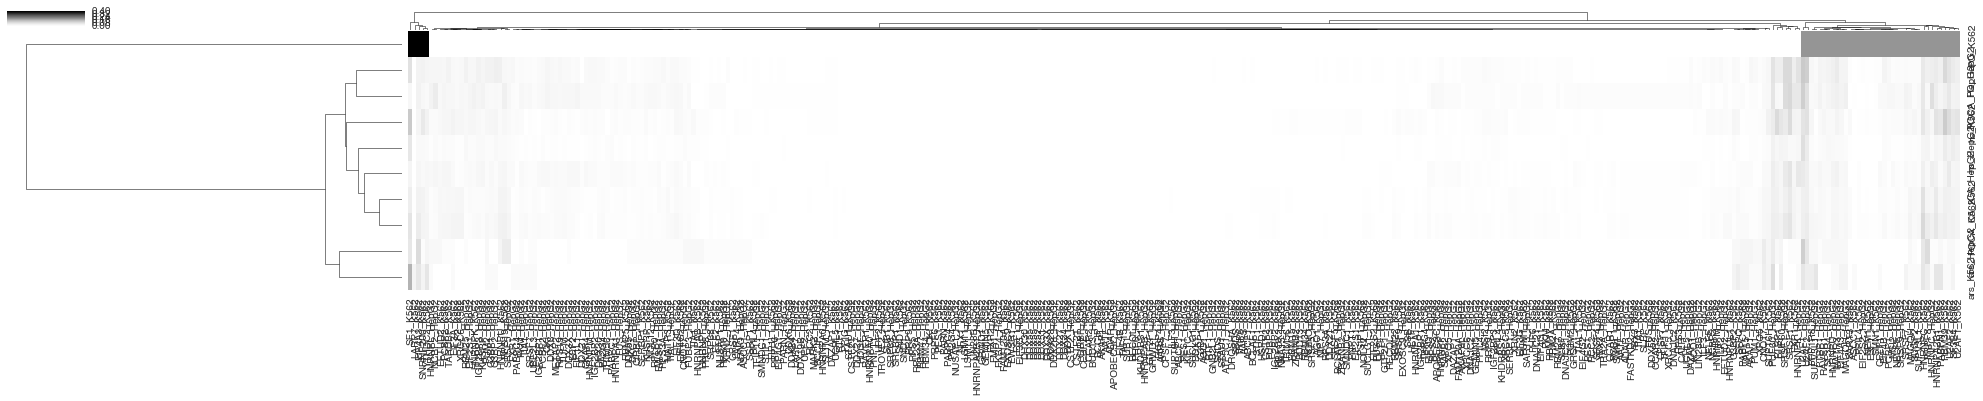

In [44]:
#Fraction of shRNA events explained by stress response
sns.clustermap(fraction_explained_by_rnai.T, cmap="Greys", figsize=(35,5))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "fraction_of_explained_events_by_rnai.svg"))
fig.savefig(os.path.join(heatmap_dir, "fraction_of_explained_events_by_rnai.pdf"))  

In [45]:
shared_matrix.sort_values("HLTF_HepG2", ascending=False)

CA_HepG2  CA_K562  DDX3X_K562  DNAJC2_HepG2  NFX1_K562  \
HLTF_HepG2            2        3           0             1          0   
PUF60_HepG2          20       31           0            16          0   
RPS19_HepG2           6       10           0             5          0   
SRSF1_HepG2          23       31           0            12          0   
U2AF1_HepG2          23       32           0            14          0   
NCBP2_HepG2          11       10           0             4          0   
IGF2BP1_HepG2         8        6           0             5          0   
U2AF2_HepG2          19       33           0            15          0   
MATR3_HepG2          16       17           0             5          0   
SF3B4_HepG2           7        8           0             1          0   
CELF1_HepG2           7        7           0             3          0   
HNRNPM_HepG2          6        3           0             7          0   
TRIM56_HepG2          4        6           0            18          0   
SUCLG1_HepG2          1        2           0             6          0   
HNRNPK_HepG2         25       18           0             6          0   
AKAP1_HepG2           5        5           0             8          0   
STIP1_HepG2           1        0           0             3          0   
SRSF5_HepG2           6       16           0            13          0   
CA_K562              65      624           0             4          0   
SLBP_HepG2            1        2           0             9          0   
SRSF1_K562           28       40           1             4          0   
PPIL4_HepG2           3        3           0            14          0   
QKI_HepG2             9        7           0             9          0   
TAF15_HepG2           5        4           0             5          0   
METAP2_HepG2          7       10           0             4          0   
CIRBP_HepG2           3        4           0             2          0   
FIP1L1_HepG2          9        7           0             6          0   
RBM25_HepG2           6        7           0             5          0   
EIF4B_HepG2           5        6           0             5          0   
DDX3X_HepG2           9        8           0             3          0   
...                 ...      ...         ...           ...        ...   
PARN_K562             0        0           0             0          0   
PA2G4_K562            0        0           0             0          0   
RECQL_K562            0        0           0             0          0   
SRP68_K562            2        4           0             0          0   
RBM34_HepG2           0        0           0             0          0   
UPF2_HepG2            0        1           0             0          0   
PHF6_K562             2        2           0             0          0   
FUS_K562              2        2           0             2          0   
DDX55_K562            0        0           0             0          0   
AKAP1_K562            0        0           0             0          0   
SBDS_HepG2            0        0           0             1          0   
DHX30_K562            0        0           0             1          0   
NPM1_K562             0        2           0             1          0   
NAA15_HepG2           0        1           0             0          0   
BCLAF1_HepG2          0        1           0             3          0   
NCBP2_K562            3        7           0             0          0   
FUBP3_K562            0        2           0             0          0   
FKBP4_K562            0        0           0             0          0   
BUD13_HepG2           0        0           0             0          0   
CCAR1_K562            2        3           0             2          1   
HNRNPF_K562           1        1           0             0          0   
GEMIN5_K562           0        0           0             0          0   
NONO_K562             0        0           0             0          0   


In [46]:
fraction_matrix.sort_values("CA_HepG2", ascending=False)

CA_HepG2   CA_K562  DDX3X_K562  DNAJC2_HepG2  NFX1_K562  \
CA_HepG2         1.000000  0.104167    0.000000          0.04        0.0   
PQCA_HepG2       0.232240  0.057692    0.000000          0.04        0.0   
CA_K562          0.177596  1.000000    0.000000          0.08        0.0   
PQCA_K562        0.144809  0.389423    0.000000          0.06        0.0   
PQ_HepG2         0.120219  0.049679    0.000000          0.14        0.0   
hs_HepG2         0.076503  0.038462    0.000000          0.08        0.0   
SRSF1_K562       0.076503  0.064103    0.142857          0.08        0.0   
HNRNPK_HepG2     0.068306  0.028846    0.000000          0.12        0.0   
SRSF1_HepG2      0.062842  0.049679    0.000000          0.24        0.0   
U2AF1_HepG2      0.062842  0.051282    0.000000          0.28        0.0   
U2AF2_K562       0.062842  0.046474    0.714286          0.06        0.0   
PUF60_HepG2      0.054645  0.049679    0.000000          0.32        0.0   
HNRNPC_HepG2     0.051913  0.030449    0.000000          0.38        0.0   
U2AF2_HepG2      0.051913  0.052885    0.000000          0.30        0.0   
HNRNPC_K562      0.049180  0.083333    0.000000          0.08        0.0   
MATR3_HepG2      0.043716  0.027244    0.000000          0.10        0.0   
HNRNPA2B1_K562   0.043716  0.062500    0.428571          0.12        0.0   
PTBP1_K562       0.040984  0.046474    0.142857          0.06        1.0   
HNRNPU_HepG2     0.038251  0.028846    0.142857          0.22        0.0   
RBM39_K562       0.038251  0.051282    0.714286          0.10        0.0   
U2AF1_K562       0.035519  0.038462    0.142857          0.06        0.0   
SF1_K562         0.035519  0.054487    0.142857          0.12        0.0   
SF3B4_K562       0.032787  0.040064    0.142857          0.04        0.0   
TARDBP_K562      0.032787  0.028846    0.000000          0.04        1.0   
PUF60_K562       0.030055  0.032051    0.142857          0.10        0.0   
RPS19_K562       0.030055  0.038462    0.285714          0.10        0.0   
EIF4A3_K562      0.030055  0.043269    0.000000          0.02        0.0   
NCBP2_HepG2      0.030055  0.016026    0.000000          0.08        0.0   
KHSRP_HepG2      0.030055  0.014423    0.000000          0.04        0.0   
PCBP2_K562       0.030055  0.024038    0.142857          0.04        1.0   
...                   ...       ...         ...           ...        ...   
DHX30_K562       0.000000  0.000000    0.000000          0.02        0.0   
DDX51_K562       0.000000  0.000000    0.000000          0.00        0.0   
SBDS_HepG2       0.000000  0.000000    0.000000          0.02        0.0   
UPF2_K562        0.000000  0.000000    0.000000          0.00        0.0   
AKAP1_K562       0.000000  0.000000    0.000000          0.00        0.0   
EXOSC9_K562      0.000000  0.000000    0.000000          0.00        1.0   
SRFBP1_K562      0.000000  0.000000    0.000000          0.00        0.0   
LIN28B_K562      0.000000  0.000000    0.000000          0.00        0.0   
RBFOX2_K562      0.000000  0.003205    0.000000          0.00        0.0   
PARN_HepG2       0.000000  0.000000    0.000000          0.06        0.0   
PRPF6_K562       0.000000  0.000000    0.000000          0.02        0.0   
FUBP3_K562       0.000000  0.003205    0.000000          0.00        0.0   
SRSF5_HepG2      0.000000  0.000000    0.000000          0.00        0.0   
HNRNPAB_K562     0.000000  0.006410    0.000000          0.00        0.0   
HNRNPA0_HepG2    0.000000  0.000000    0.000000          0.04        0.0   
ABCF1_K562       0.000000  0.000000    0.000000          0.00        0.0   
BCLAF1_K562      0.000000  0.004808    0.000000          0.04        0.0   
SMNDC1_K562      0.000000  0.000000    0.000000          0.00        0.0   
SND1_HepG2       0.000000  0.000000    0.000000          0.04        0.0   
NONO_K562        0.000000  0.000000    0.000000          0.00        0.0   
GEMIN5_K562      0.000000  0.000000    0.000000          0.00    

In [ ]:
fraction_explained_by_rnai.sort_values("CA_HepG2", ascending=False)

CA_HepG2   CA_K562  PQ_HepG2  PQ_K562  PQCA_HepG2  PQCA_K562  \
SRSF1_K562      0.076503  0.064103  0.097372      0.0    0.102941   0.077754   
HNRNPK_HepG2    0.068306  0.028846  0.080371      0.0    0.068627   0.023758   
SRSF1_HepG2     0.062842  0.049679  0.098918      0.0    0.093137   0.064795   
U2AF1_HepG2     0.062842  0.051282  0.126739      0.2    0.117647   0.051836   
U2AF2_K562      0.062842  0.046474  0.075734      0.2    0.068627   0.043197   
PUF60_HepG2     0.054645  0.049679  0.078825      0.0    0.073529   0.053996   
HNRNPC_HepG2    0.051913  0.030449  0.054096      0.2    0.088235   0.045356   
U2AF2_HepG2     0.051913  0.052885  0.117465      0.2    0.083333   0.060475   
HNRNPC_K562     0.049180  0.083333  0.064915      0.2    0.068627   0.101512   
HNRNPA2B1_K562  0.043716  0.062500  0.061824      0.2    0.053922   0.071274   
MATR3_HepG2     0.043716  0.027244  0.061824      0.2    0.049020   0.032397   
PTBP1_K562      0.040984  0.046474  0.054096      0.0    0.024510   0.051836   
HNRNPU_HepG2    0.038251  0.028846  0.051005      0.2    0.044118   0.030238   
RBM39_K562      0.038251  0.051282  0.100464      0.2    0.049020   0.053996   
U2AF1_K562      0.035519  0.038462  0.052550      0.2    0.044118   0.038877   
SF1_K562        0.035519  0.054487  0.081917      0.4    0.029412   0.075594   
SF3B4_K562      0.032787  0.040064  0.061824      0.2    0.039216   0.045356   
TARDBP_K562     0.032787  0.028846  0.041731      0.0    0.029412   0.032397   
FXR1_K562       0.030055  0.038462  0.055641      0.0    0.068627   0.041037   
EIF4A3_K562     0.030055  0.043269  0.041731      0.4    0.044118   0.060475   
RPS19_K562      0.030055  0.038462  0.029366      0.0    0.049020   0.045356   
PCBP2_K562      0.030055  0.024038  0.029366      0.0    0.034314   0.030238   
NCBP2_HepG2     0.030055  0.016026  0.032457      0.0    0.058824   0.012959   
KHSRP_HepG2     0.030055  0.014423  0.034003      0.0    0.039216   0.015119   
PUF60_K562      0.030055  0.032051  0.054096      0.0    0.019608   0.043197   
PTBP1_HepG2     0.030055  0.022436  0.037094      0.2    0.039216   0.023758   
MAGOH_HepG2     0.027322  0.022436  0.038640      0.2    0.049020   0.028078   
IGF2BP3_HepG2   0.027322  0.012821  0.043277      0.0    0.034314   0.021598   
YTHDC2_K562     0.027322  0.025641  0.035549      0.4    0.019608   0.034557   
HNRNPU_K562     0.027322  0.036859  0.051005      0.0    0.019608   0.043197   
...                  ...       ...       ...      ...         ...        ...   
SBDS_HepG2      0.000000  0.000000  0.003091      0.0    0.000000   0.000000   
SBDS_K562       0.000000  0.001603  0.003091      0.0    0.000000   0.002160   
FKBP4_K562      0.000000  0.000000  0.001546      0.0    0.000000   0.000000   
FKBP4_HepG2     0.000000  0.000000  0.000000      0.0    0.000000   0.000000   
FIP1L1_K562     0.000000  0.003205  0.004637      0.0    0.004902   0.002160   
FAM120A_K562    0.000000  0.000000  0.000000      0.0    0.000000   0.000000   
EXOSC9_K562     0.000000  0.000000  0.000000      0.0    0.000000   0.000000   
PARN_K562       0.000000  0.000000  0.000000      0.0    0.000000   0.000000   
EWSR1_K562      0.000000  0.000000  0.000000      0.0    0.000000   0.000000   
ESF1_K562       0.000000  0.000000  0.000000      0.0    0.000000   0.000000   
ESF1_HepG2      0.000000  0.001603  0.006182      0.2    0.000000   0.004320   
FXR2_K562       0.000000  0.000000  0.000000      0.0    0.000000   0.000000   
RRP9_K562       0.000000  0.000000  0.000000      0.0    0.000000   0.000000   
RPS5_HepG2      0.000000  0.000000  0.000000      0.0    0.000000   0.000000   
RPL23A_HepG2    0.000000  0.000000  0.000000      0.0    0.000000   0.000000   
RBM34_K562      0.000000  0.000000  0.001546      0.0    0.000000   0.000000   
RBM47_HepG2     0.000000  0.000000  0.000000      0.0    0.000000   0.000000   
HNRNPA0_HepG2   0.000000  0.000000  0.000000      0.0    0.000000   0.000000   
RCC2_K562       

In [1]:
num_rows = 1
num_cols = len(fraction_explained_by_rnai.index)
with dataviz.Figure(os.path.join(heatmap_dir, "sorted_explained_events.svg"), figsize=( num_cols * 5, num_rows * 35)) as fig:
    for x, stress_event in enumerate(fraction_explained_by_rnai.columns):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)
        sns.barplot(x=fraction_explained_by_rnai.loc[:,stress_event].sort_values(ascending=False), 
                    y=fraction_explained_by_rnai.loc[:,stress_event].sort_values(ascending=False).index,
                   ax=ax)
        ax.set_title(stress_event)
        sns.despine(ax=ax)

NameError: name 'fraction_explained_by_rnai' is not defined

In [ ]:
num_rows = 1
num_cols = len(fraction_explained_by_rnai.index)
with dataviz.Figure(os.path.join(heatmap_dir, "sorted_filtered_explained_events.svg"), figsize=( num_cols * 5, num_rows * 5)) as fig:
    
    for x, stress_event in enumerate(fraction_explained_by_rnai.columns):
        ax = fig.add_subplot(num_rows, num_cols, x + 1)
        sns.barplot(x=fraction_explained_by_rnai.loc[:,stress_event].sort_values(ascending=False)[:10], 
                    y=fraction_explained_by_rnai.loc[:,stress_event].sort_values(ascending=False).index[:10],
                   ax=ax)
        ax.set_title(stress_event)
        sns.despine(ax=ax)

any one RBP explains very few differental splicing events upon stress, but what about all the events, can all the RNA knockdowns combined explain more events?
Tighten up psi scores and look for commonality in events
Do this per cell type, not intra-cell types


In [ ]:
fraction_explained_by_rnai.index = pd.MultiIndex.from_tuples(fraction_explained_by_rnai.index.map(lambda x: tuple(x.split("_"))), names=['rbp', 'cell_type'])
fraction_explained_by_rnai.columns = pd.MultiIndex.from_tuples(fraction_explained_by_rnai.columns.map(lambda x: tuple(x.split("_"))), names=['rbp', 'cell_type'])

fraction_explained_by_rnai_hepg2 = fraction_explained_by_rnai.xs("HepG2", level="cell_type").xs("HEPG2", level="cell_type", axis=1)
fraction_explained_by_rnai_k562 = fraction_explained_by_rnai.xs("K562", level="cell_type").xs("K562", level="cell_type", axis=1)

In [ ]:
#Fraction of shRNA events explained by stress response
sns.clustermap(fraction_explained_by_rnai_hepg2, cmap="Greys", figsize=(20,2))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "fraction_explained_by_rnai_hepg2.svg"))
fig.savefig(os.path.join(heatmap_dir, "fraction_explained_by_rnai_hepg2.pdf"))  

sns.clustermap(fraction_explained_by_rnai_k562, cmap="Greys", figsize=(20,2))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "fraction_explained_by_rnai_k562.svg"))
fig.savefig(os.path.join(heatmap_dir, "fraction_explained_by_rnai_k562.pdf"))  

In [ ]:
num_rows = 1
num_cols = len(fraction_explained_by_rnai.index)
with dataviz.Figure(os.path.join(heatmap_dir, "sorted_explained_events_cell_type_specific.svg"), figsize=( num_cols * 5, num_rows * 20)) as fig:
    count = 0
    for x, stress_event in enumerate(fraction_explained_by_rnai_hepg2.index):
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        sns.barplot(x=fraction_explained_by_rnai_hepg2.ix[stress_event].sort_values(ascending=False), 
                    y=fraction_explained_by_rnai_hepg2.ix[stress_event].sort_values(ascending=False).index,
                   ax=ax)
        ax.set_title(stress_event)
        sns.despine(ax=ax)
    
    for x, stress_event in enumerate(fraction_explained_by_rnai_k562.index):
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        sns.barplot(x=fraction_explained_by_rnai_k562.ix[stress_event].sort_values(ascending=False), 
                    y=fraction_explained_by_rnai_k562.ix[stress_event].sort_values(ascending=False).index,
                   ax=ax)
        ax.set_title(stress_event)
        sns.despine(ax=ax)

In [ ]:
num_rows = 1
num_cols = len(fraction_explained_by_rnai.index)
with dataviz.Figure(os.path.join(heatmap_dir, "sorted_filtered_explained_events_cell_type_specific.svg"), figsize=( num_cols * 5, num_rows * 5)) as fig:
    count = 0
    for x, stress_event in enumerate(fraction_explained_by_rnai_hepg2.index):
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        sns.barplot(x=fraction_explained_by_rnai_hepg2.ix[stress_event].sort_values(ascending=False)[:10], 
                    y=fraction_explained_by_rnai_hepg2.ix[stress_event].sort_values(ascending=False).index[:10],
                   ax=ax)
        ax.set_title("HepG2 " + stress_event)
        sns.despine(ax=ax)
    
    for x, stress_event in enumerate(fraction_explained_by_rnai_k562.index):
        count += 1
        ax = fig.add_subplot(num_rows, num_cols, count)
        sns.barplot(x=fraction_explained_by_rnai_k562.ix[stress_event].sort_values(ascending=False)[:10], 
                    y=fraction_explained_by_rnai_k562.ix[stress_event].sort_values(ascending=False).index[:10],
                   ax=ax)
        ax.set_title("K562 " + stress_event)
        sns.despine(ax=ax)

In [ ]:
num_rows = 1
num_cols = 2 
#fraction of events that are bound proximally by RBP for just stressed events
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_shared_stress_events_cell_type.svg"), figsize=(num_cols * 3, num_rows * 3)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    se_events = all_sig_stress_events.xs("SE").xs("HepG2", level="cell_type").dropna(how="all", axis=1)    
    counts = Counter(se_events.groupby("group_id").count().FDR)
    
    sns.barplot(x=counts.keys(), y=counts.values(), color='b', ax=ax)
    sns.despine()
    ax.set_title("Number of Shared Events HepG2")
    ax.set_ylabel("Number of Splicing Events")
    ax.set_xlabel("Number of Conditions Shared")
    ax.set_ylim(0,7000)
    
    ax = fig.add_subplot(num_rows,num_cols,2)
    se_events = all_sig_stress_events.xs("SE").xs("K562", level="cell_type").dropna(how="all", axis=1)    
    counts = Counter(se_events.groupby("group_id").count().FDR)
    
    sns.barplot(x=counts.keys(), y=counts.values(), color='b', ax=ax)
    sns.despine()
    ax.set_title("Number of Shared Events K562")
    ax.set_ylabel("Number of Splicing Events")
    ax.set_xlabel("Number of Conditions Shared")
    ax.set_ylim(0,7000)

In [ ]:
#fraction of events that are bound proximally by RBP for just stressed events
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_shared_stress_events.svg"), figsize=(3, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    se_events = all_sig_stress_events.xs("SE").dropna(how="all", axis=1)
    counts = Counter(se_events.groupby("group_id").count().FDR)
    
    sns.barplot(x=counts.keys(), y=counts.values(), color='b', ax=ax)
    sns.despine()
    ax.set_title("Number of Shared Events")
    ax.set_ylabel("Number of Splicing Events")
    ax.set_xlabel("Number of Conditions Shared")

Work of defining a core splicing code between cell types

In [ ]:
sns.clustermap(jaccard_matrix.ix[stress_ids][stress_ids], figsize=(7,7))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "jaccard_of_shared_stress_events.svg"))
fig.savefig(os.path.join(heatmap_dir, "jaccard_of_shared_stress_events.pdf"))  

In [ ]:
sns.clustermap(fraction_matrix.ix[stress_ids][stress_ids], figsize=(7,7))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "fraction_of_shared_stress_events.svg"))
fig.savefig(os.path.join(heatmap_dir, "fraction_of_shared_stress_events.pdf"))  

In [ ]:
num_rows = 3
num_cols = 2
#fraction of events that are bound proximally by RBP for just stressed events
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_shared_stress_events_cell_type.svg"), figsize=(num_cols * 2.5, num_rows * 2.5)) as fig:
    
    for x, (name, df) in enumerate(se_events.groupby("rbp")):
        ax = fig.add_subplot(num_rows,num_cols, x + 1)
        by_cell_type = df.groupby("cell_type")
        
        hepg2_events = by_cell_type.get_group("HepG2").group_id.values
        k562_events = by_cell_type.get_group("K562").group_id.values
        venn2([set(hepg2_events), set(k562_events)], set_labels=['HepG2', 'K562'])
        ax.set_title(name)

In [ ]:
num_rows = 3
num_cols = 2
#fraction of events that are bound proximally by RBP for just stressed events
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_shared_stress_events_pqca.svg"), figsize=(num_cols * 2.5, num_rows * 2.5)) as fig:
    
    for x, (name, df) in enumerate(se_events.groupby("cell_type")):
        ax = fig.add_subplot(num_rows,num_cols, x + 1)
        by_cell_type = df.groupby("rbp")
        
        pq_events = by_cell_type.get_group("PQ").group_id.values
        ca_events = by_cell_type.get_group("CA").group_id.values
        pqca_events = by_cell_type.get_group("PQCA").group_id.values

        venn3([set(pq_events), set(ca_events), set(pqca_events)], set_labels=['PQ', 'CA', 'PQ/CA'])
        ax.set_title(name)

#Go Analysis on spliced exons

In [ ]:
hg19go = GO.GO(GOFile="/projects/ps-yeolab/genomes/hg19/hg19.ENSG_to_GO.txt.gz")
def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]

In [ ]:
result = {}
for name, df in se_events.groupby(['rbp', 'cell_type']):
    enrichment = hg19go.enrichment(gencode_to_ensembl(df.GeneID))
    enrichment = enrichment[enrichment['Bonferroni-corrected Hypergeometric p-Value'] < .05]
    result[name] = enrichment
    
go_analysis = pd.concat(result, names=['condition', 'GO Term Accession'])

In [ ]:
dataviz.plot_go_enrichment(go_analysis, figsize=(15,60))

In [ ]:
dataviz.plot_go_enrichment(go_analysis, figsize=(5,5), max_terms=15)
fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "go_on_differentally_spliced.svg"))
fig.savefig(os.path.join(heatmap_dir, "go_on_differentally_spliced.pdf"))  

do the expression level analysis

I'll make a list of positive controls, found a few known splicing events already.  Sebastian also mentioned that he knew a few

Try to define core set of splice responsive stressors

ok, for fig 2, it'll be interesting to see if there's a core set of stress responsive alternative exons, the venn diagram here would be interesting



splicing stress response is largely unique except in the case of PQCA and CA which overlap.  It also looks like the CA treatment is driving the splicing changes not the PQ treatment

The cryptic exon finder also finds annotated exons, also the way they define exons is something I'll need to look into.  Its not consistant between experiments, which doesn't make much sense to me.  

#Lets look at known SG proteins

In [ ]:
sg_rbps = pd.read_csv("/home/gpratt/Dropbox/cryptic_splicing/data/clip/KnownSGprot_long.csv")

In [ ]:
internal_stress_fraction_bound = internal_fraction_enriched.ix[stress_conditions].fillna(0)

In [ ]:
sg_internal_fraction = internal_stress_fraction_bound[internal_stress_fraction_bound.columns & sg_rbps['Gene Symbol']]
not_sg_internal_fraction = internal_stress_fraction_bound[internal_stress_fraction_bound.columns.difference(sg_rbps['Gene Symbol'])]

In [ ]:
#fraction of events that are bound proximally by RBP
num_rows = len(sg_internal_fraction.index)
num_cols = 1
with dataviz.Figure(os.path.join(heatmap_dir, "sg_plot.svg"), figsize=(num_cols * 6, num_rows * 3)) as fig:
    for x, condition in enumerate(sg_internal_fraction.index):
        
        ax = fig.add_subplot(len(sg_internal_fraction.index),1,x + 1)

        sns.distplot(sg_internal_fraction.ix[condition], hist=False, label="Stress Granule RBP")
        sns.distplot(not_sg_internal_fraction.ix[condition], hist=False, label="Not Stress Granule RBP")
        sns.despine(ax=ax)
        ax.set_title(condition)
        ax.set_xlabel("Fraction of events bound by RBP")
        ax.set_ylabel("Number of RBPs")


In [ ]:
intersting_rbps = [(u'PQ', "HepG2"), (u'hs', "HepG2"),
                  (u'PQ', "K562"), (u'hs', "K562")]

In [ ]:
#fraction of events that are bound proximally by RBP
num_rows = len(intersting_rbps) / 2 
num_cols = 2
with dataviz.Figure(os.path.join(heatmap_dir, "sg_plot_limited.svg"), figsize=(num_cols * 6, num_rows * 3)) as fig:
    for x, condition in enumerate(intersting_rbps):
        
        ax = fig.add_subplot(num_rows,2,x + 1)

        sns.distplot(sg_internal_fraction.ix[condition], hist=False, label="Stress Granule RBP")
        sns.distplot(not_sg_internal_fraction.ix[condition], hist=False, label="Not Stress Granule RBP")
        sns.despine(ax=ax)
        ax.set_title(condition)
        ax.set_xlabel("Fraction of events bound by RBP")
        ax.set_ylabel("Number of RBPs")

Filter SG proteins by RBPs normally localized in the nucleus 

Email Eric get new binary list of RBP localization
Get Ron to run APA stuff on the data